In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import tensorflow as tf
import gzip
from PIL import Image
import io
import numpy as np
import pickle

In [ ]:
import torch

In [ ]:
import torch
from torch.utils.data import Dataset
import tensorflow as tf
import pickle
import numpy as np
from tqdm import tqdm
class FireDataset(Dataset):
    def __init__(self, dataframe, tfrecord_paths, features_path):
        self.dataframe = dataframe
        self.preloaded_images = {}
        with open(features_path, "rb") as f:
            self.features_dict = pickle.load(f)
        self._preload_images(tfrecord_paths)
        self.number_features = dataframe.iloc[0].drop(['export_index', 'report_id', 'id', 'next_area_diff']).shape[0]


    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        features = torch.tensor(row.drop(['export_index', 'report_id', 'id', 'next_area_diff']).values.astype(float), dtype=torch.float)
        target = torch.tensor(row['next_area_diff'], dtype=torch.float)
        images_key = (row['export_index'], int(row['day_since_first_report']))
        images_tensor = self.preloaded_images.get(images_key, torch.zeros(7, 64, 64, dtype=torch.float))

        return features, images_tensor, target

    def _preload_images(self, tfrecord_paths):
        for index, row in tqdm(self.dataframe.iterrows(), total=self.dataframe.shape[0]):
            export_index = row['export_index']
            day_since_first_report = int(row['day_since_first_report'])
            key = (export_index, day_since_first_report)

            if key not in self.preloaded_images:
                tfrecord_path = tfrecord_paths.get(export_index)
                if tfrecord_path:
                    self.preloaded_images[key] = self.load_and_parse_tfrecord(tfrecord_path, day_since_first_report)
                else:
                    print(f"TFRecord path for export_index {export_index} not found.")

    def load_and_parse_tfrecord(self, tfrecord_path, day_since_first_report):

        layers = ['pr', 'sph', 'th', 'tmmn', 'tmmx', 'vs', 'erc']
        day = f"{day_since_first_report:02}"
        images_array = np.zeros((7, 64, 64))

        raw_dataset = tf.data.TFRecordDataset(tfrecord_path, compression_type='GZIP')
        for raw_record in raw_dataset.take(1): # one record per dataset
            example = tf.io.parse_single_example(raw_record, self.features_dict)
            for i, layer in enumerate(layers):
                key = f'{day}_{layer}'
                if key in example:
                    images_array[i] = example[key].numpy()
                else:
                    print(f"Key {key} not found in TFRecord.")

        return  torch.tensor(images_array, dtype=torch.float)



In [ ]:
df = pd.read_csv("request_data.csv", index_col=0)

In [ ]:
import ee
ee.Authenticate()
ee.Initialize(project='wildfire-lab')
from google.cloud import storage
client = storage.Client()

In [ ]:
bucket = "wildfire-lab"
folder = "batch_export_419"

def _get_fire_paths_gc(bucket, folder):
    client = storage.Client()
    blobs = client.list_blobs(bucket, prefix=folder)
    paths = {}
    for blob in blobs:
      fire_nb = blob.name.split('/')[-1].split('.')[0].split('fire')[-1]
      path = f"gs://{bucket}/{folder}/fire{fire_nb}.tfrecord.gz"
      paths[int(fire_nb)] = path
    return paths
image_paths = _get_fire_paths_gc(bucket,folder)

In [ ]:
# some missing number lol
for i in range(3139):
  try:
    x = image_paths[i]
  except:
    print(i)

731
2447


In [ ]:
keys = list(image_paths.keys())

In [ ]:
diff = [a-b for a,b in zip(keys[1:], keys[:len(keys)])]

In [ ]:
from operator import itemgetter
index, element = max(enumerate(diff), key=itemgetter(1))

In [ ]:
def find_missing_number(arr, n):
    expected_sum = n * (n - 1) // 2
    actual_sum = sum(arr)
    return expected_sum - actual_sum
find_missing_number(keys[:3139], 3140)

38

In [ ]:
def load_dataset(from_disk=False, path=''):
  if from_disk:
    return torch.load(path)

  else:
    dataframe = df
    tfrecord_paths = image_paths
    features_path = "/content/band_features.pkl"
    dataset = FireDataset(dataframe, tfrecord_paths, features_path)
    return dataset
dataset = load_dataset("./dataset.pt")

FileNotFoundError: [Errno 2] No such file or directory: ''

Report index: 0, fire id: 2015_2714022_BAYLE MOUNTAIN


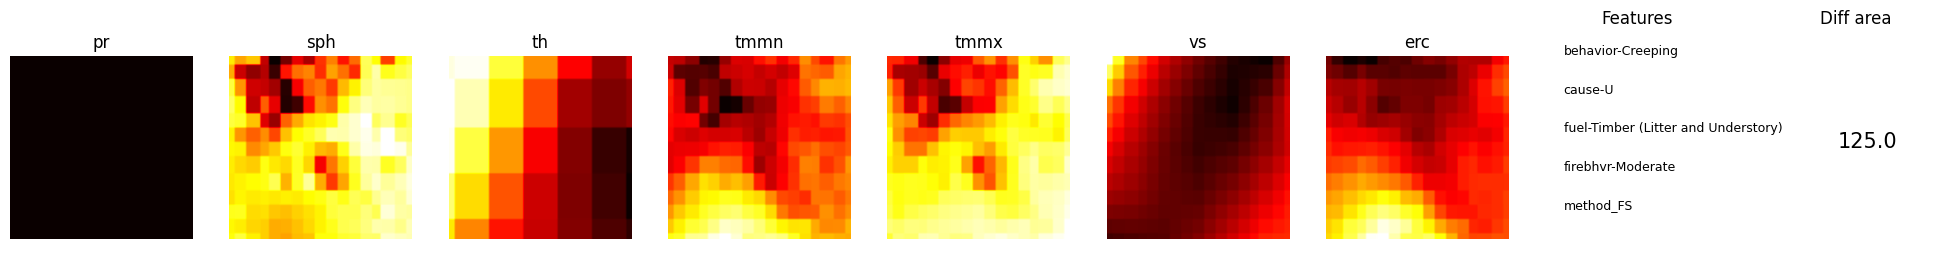

Report index: 1, fire id: 2015_2714022_BAYLE MOUNTAIN


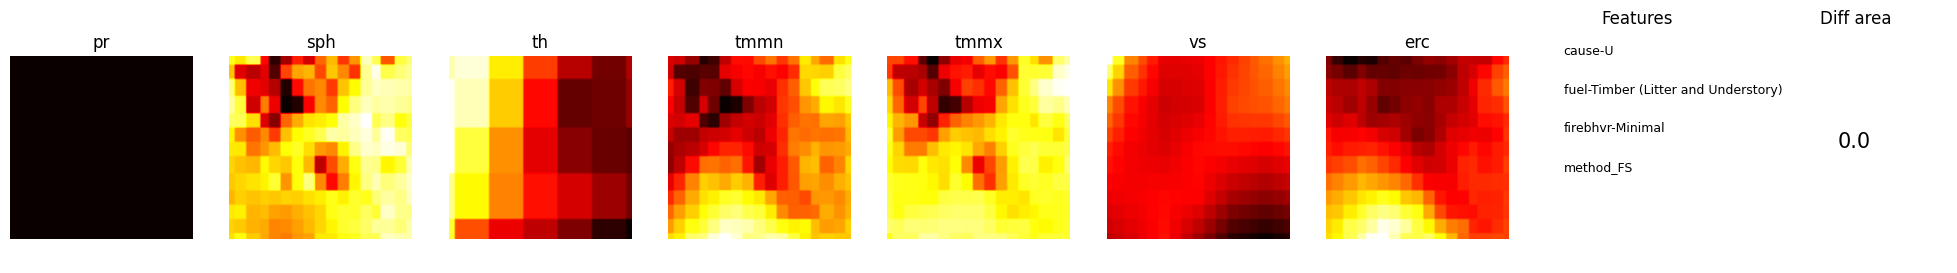

Report index: 2, fire id: 2015_2714022_BAYLE MOUNTAIN


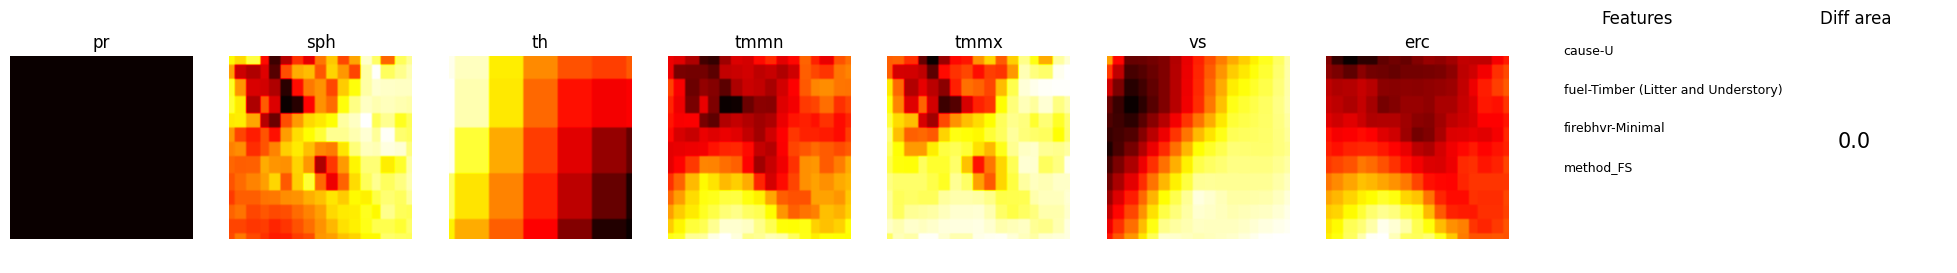

Report index: 3, fire id: 2015_2714081_BOOT COVE FIRE


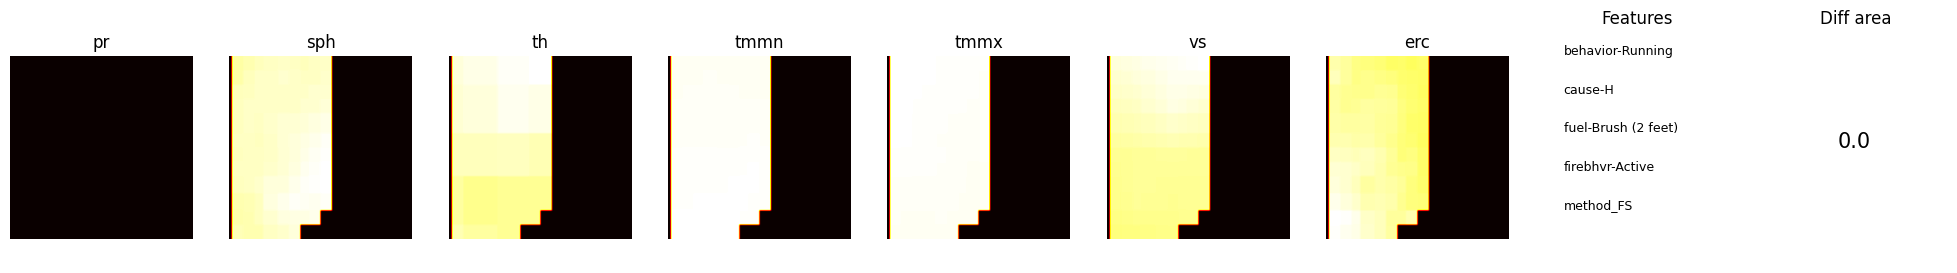

Report index: 4, fire id: 2015_2714081_BOOT COVE FIRE


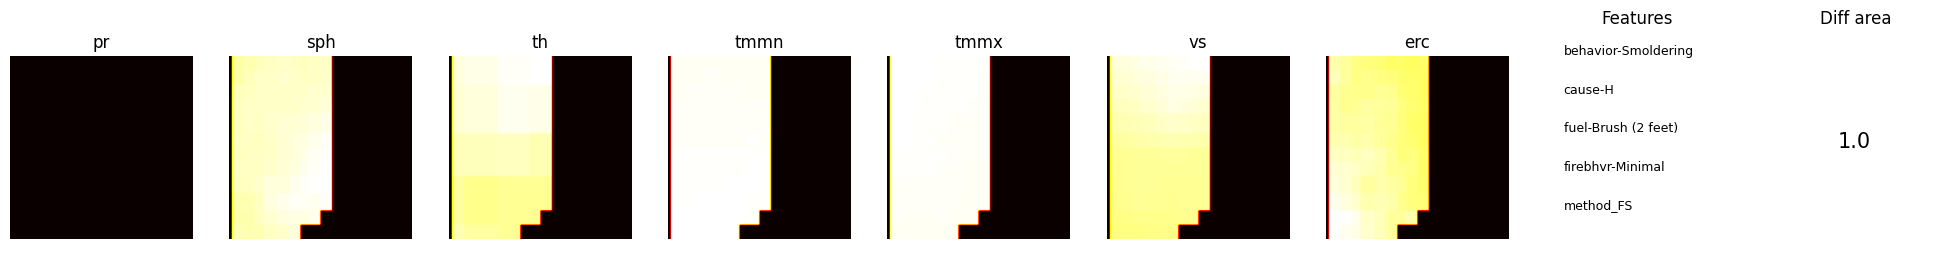

Report index: 5, fire id: 2015_2714215_ATHENS


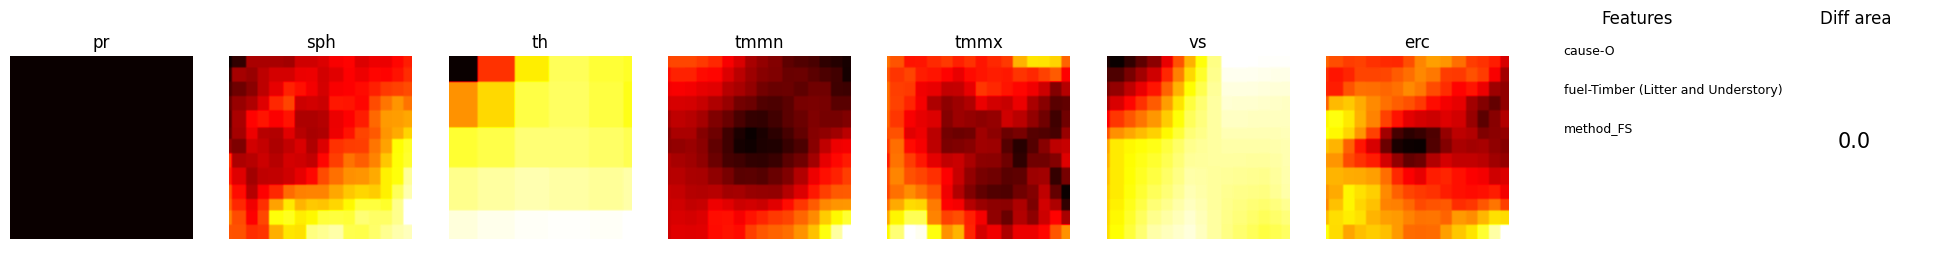

Report index: 6, fire id: 2015_2714294_PINEY ACRES TRAIL


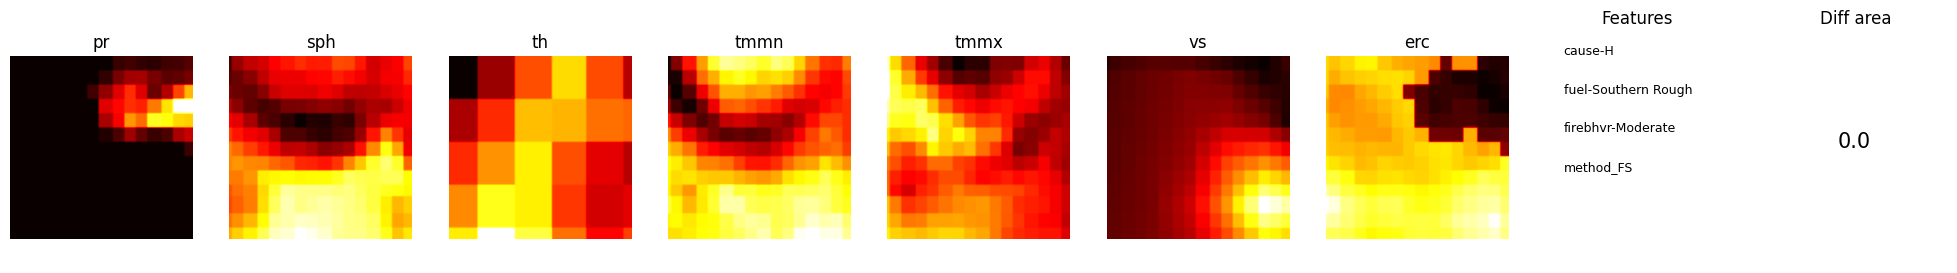

Report index: 7, fire id: 2015_2714324_WILD HERON WAY


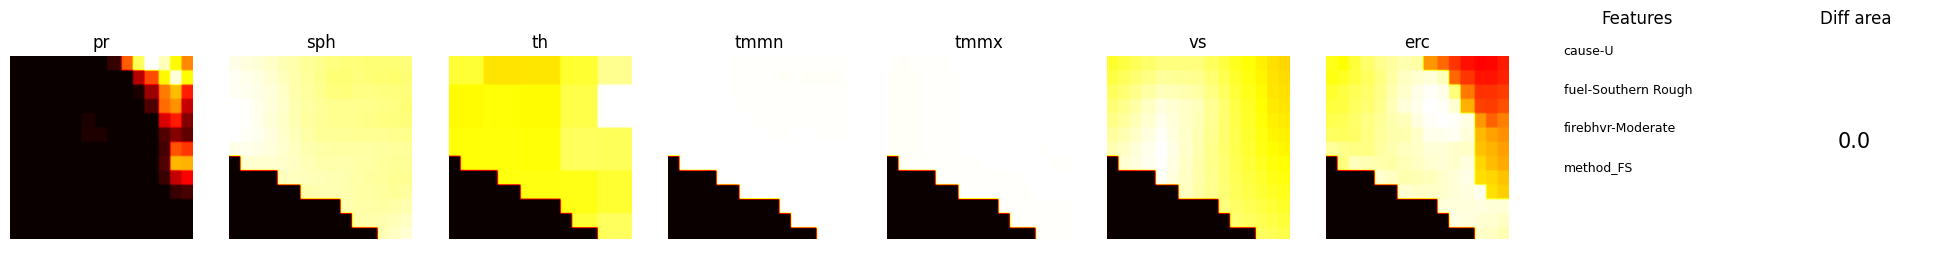

Report index: 8, fire id: 2015_2714324_WILD HERON WAY


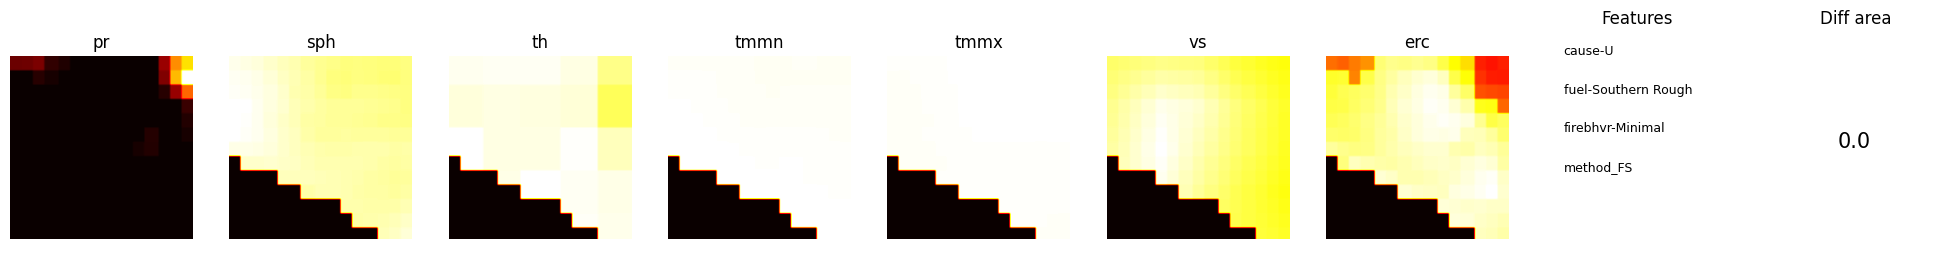

Report index: 9, fire id: 2015_2714324_WILD HERON WAY


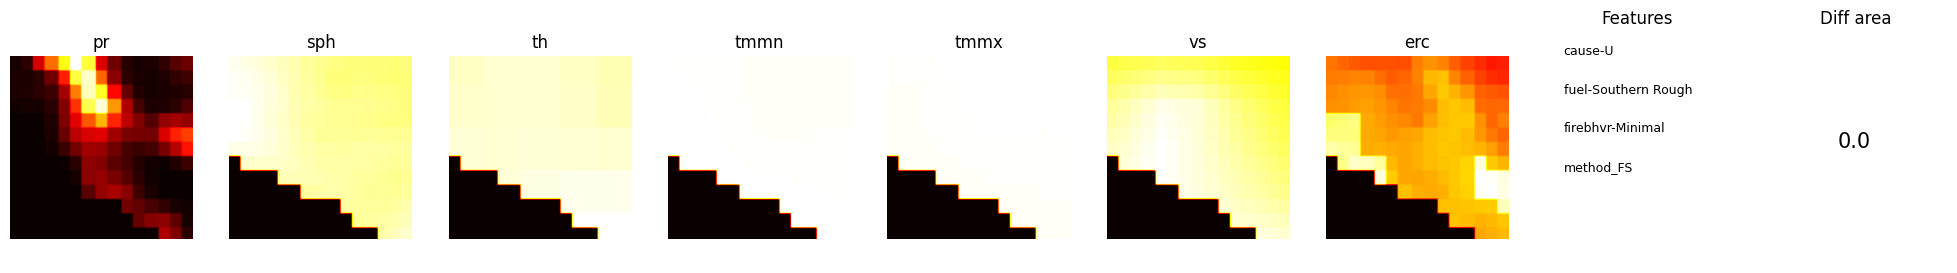

Report index: 10, fire id: 2015_2714324_WILD HERON WAY


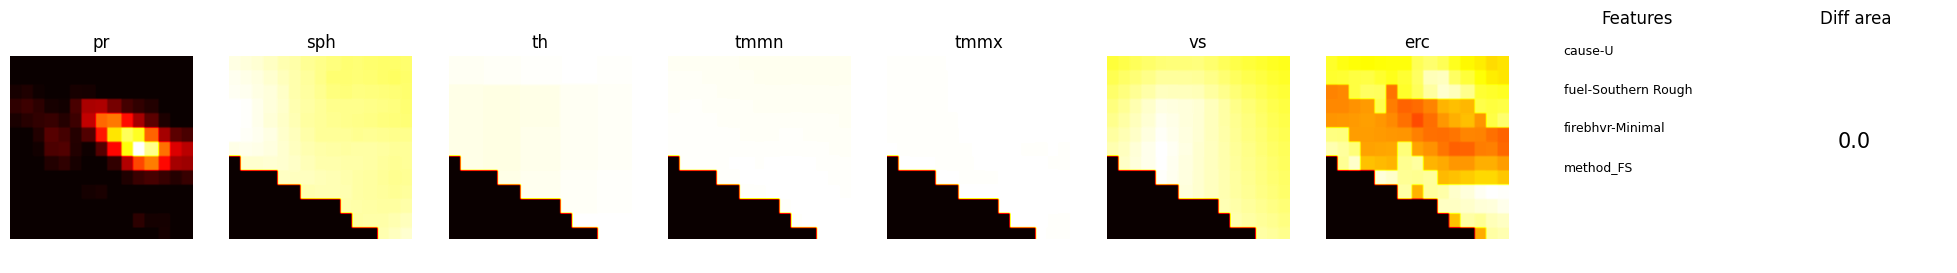

Report index: 11, fire id: 2015_2714324_WILD HERON WAY


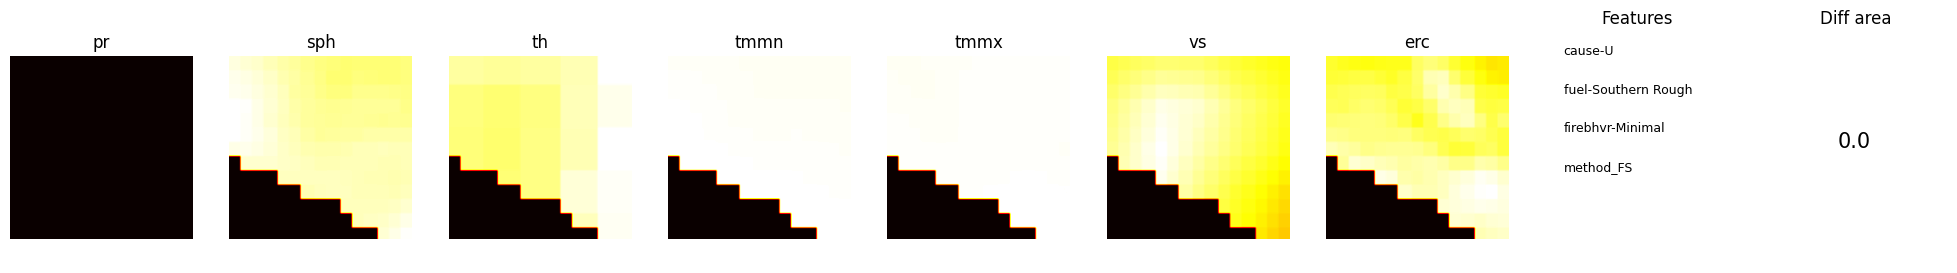

Report index: 12, fire id: 2015_2714324_WILD HERON WAY


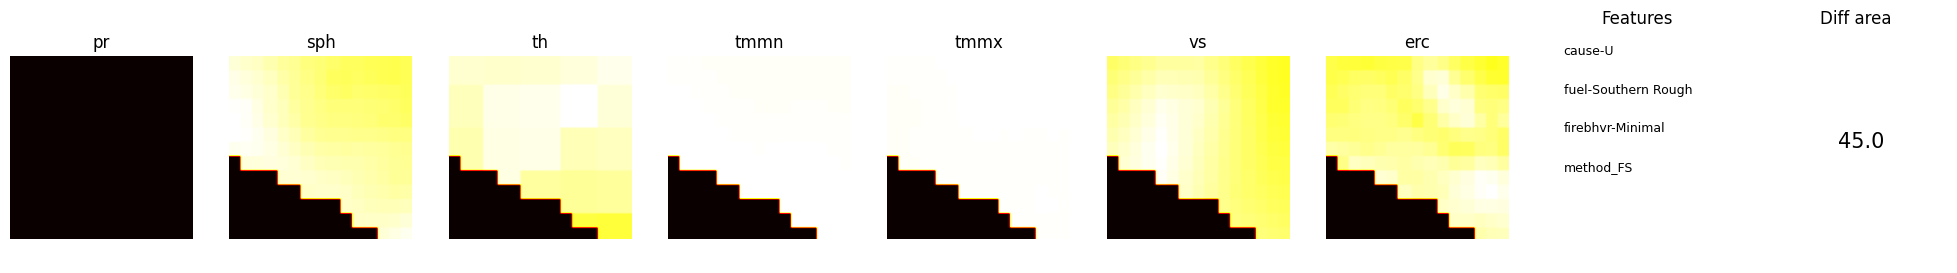

Report index: 13, fire id: 2015_2714324_WILD HERON WAY


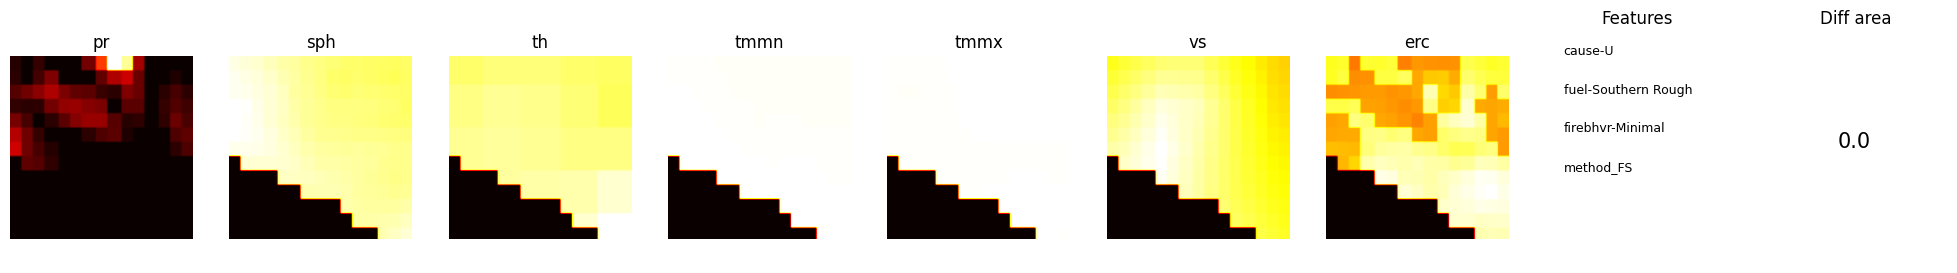

Report index: 14, fire id: 2015_2714324_WILD HERON WAY


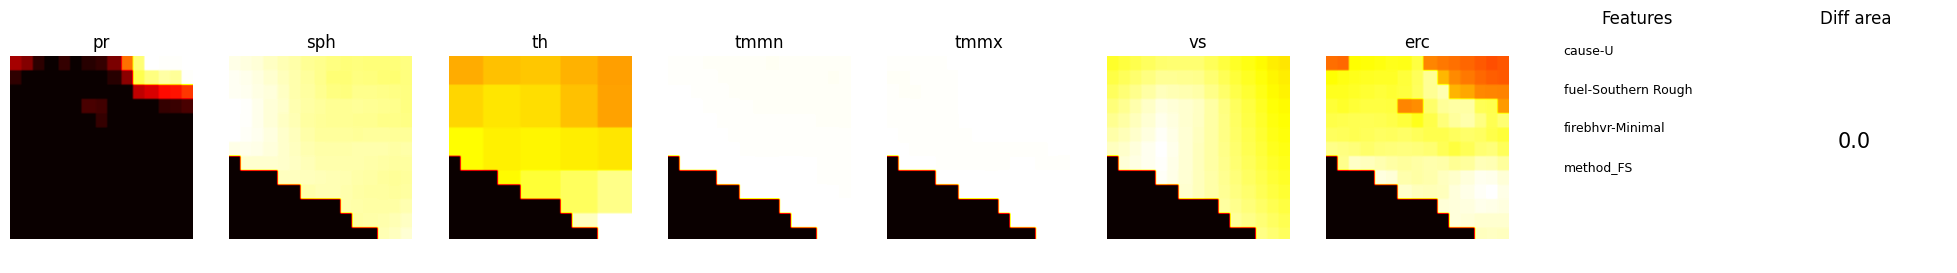

Report index: 15, fire id: 2015_2714324_WILD HERON WAY


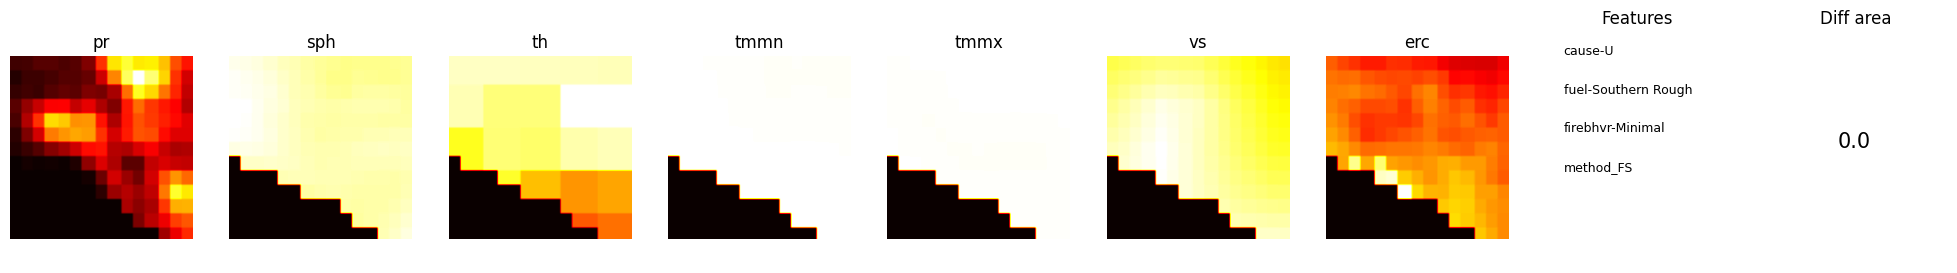

Report index: 16, fire id: 2015_2714431_PINE STREET


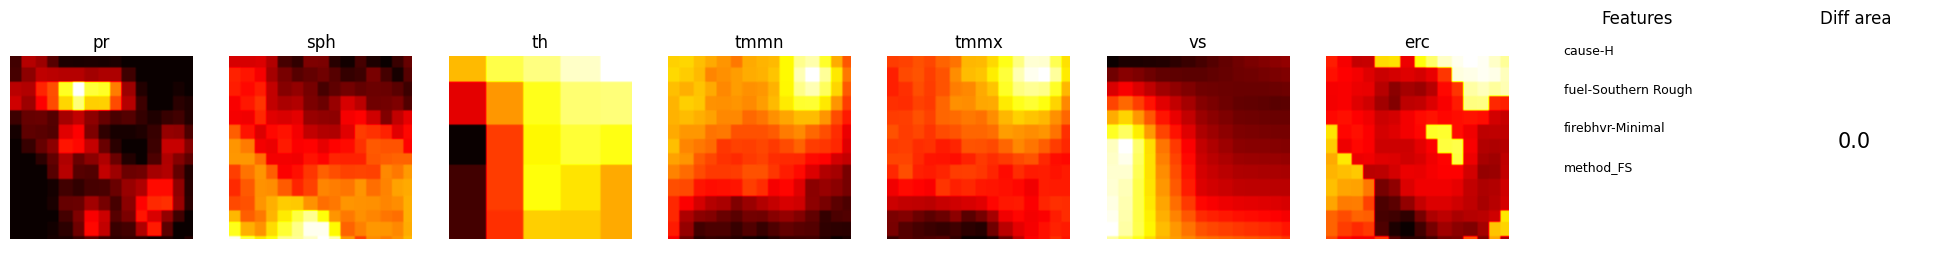

Report index: 17, fire id: 2015_2714431_PINE STREET


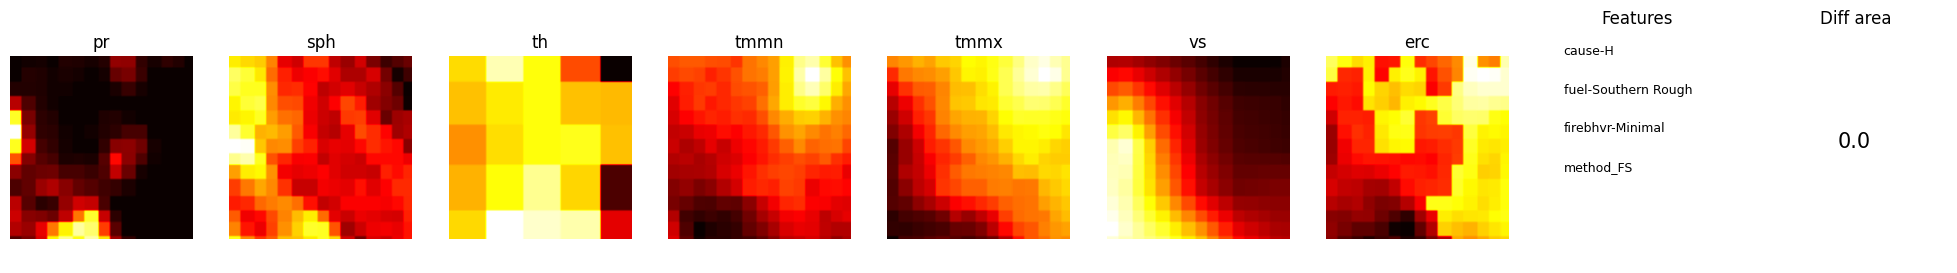

Report index: 18, fire id: 2015_2714466_BOLGEN CREEK


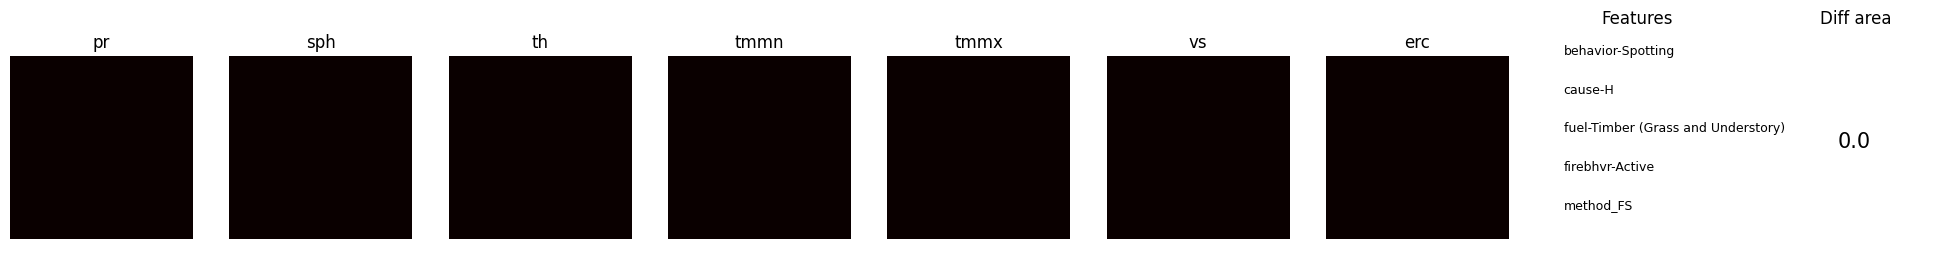

Report index: 19, fire id: 2015_2714466_BOLGEN CREEK


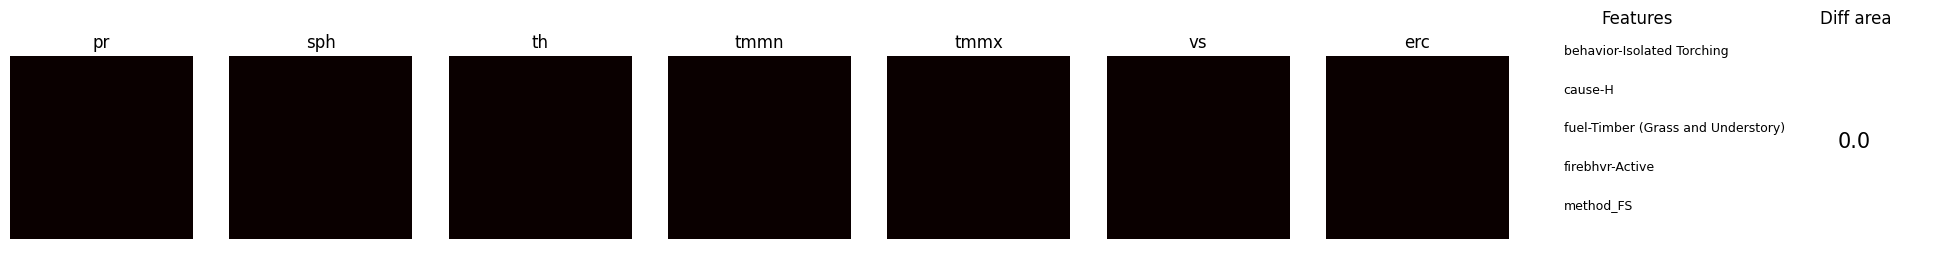

Report index: 20, fire id: 2015_2714466_BOLGEN CREEK


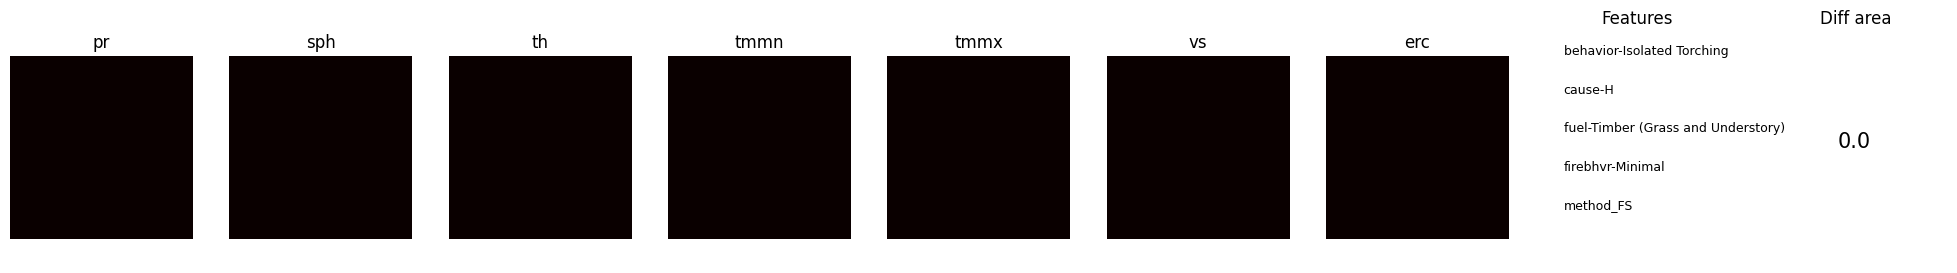

Report index: 21, fire id: 2015_2714466_BOLGEN CREEK


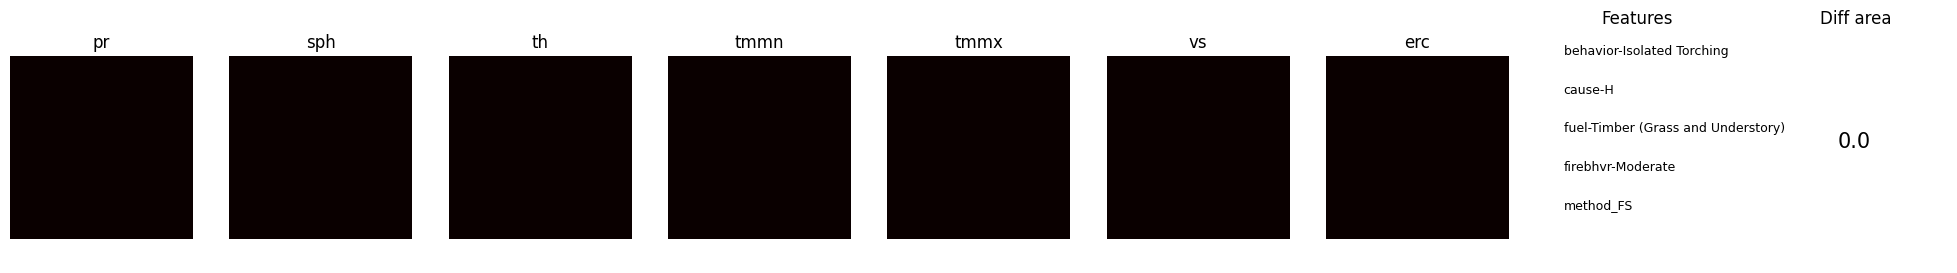

Report index: 22, fire id: 2015_2714466_BOLGEN CREEK


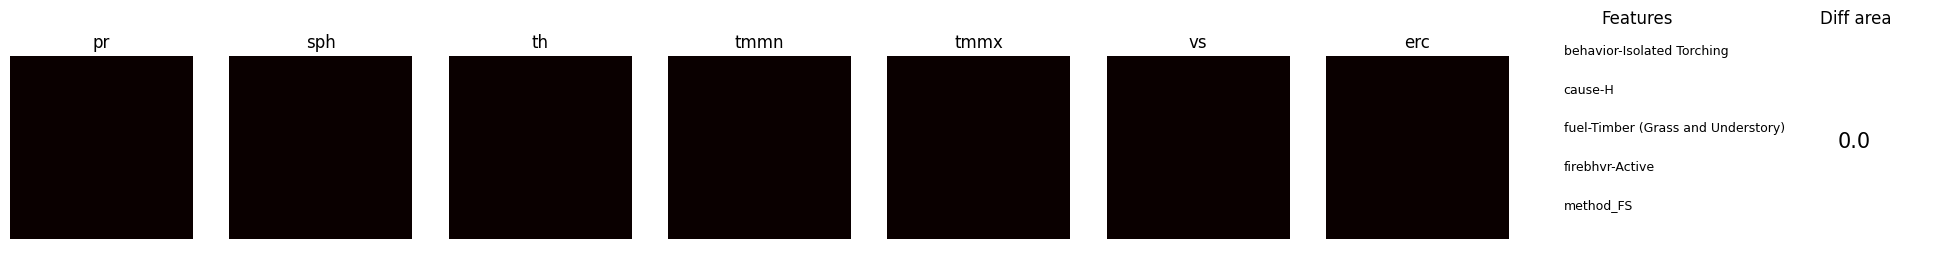

Report index: 23, fire id: 2015_2714466_BOLGEN CREEK


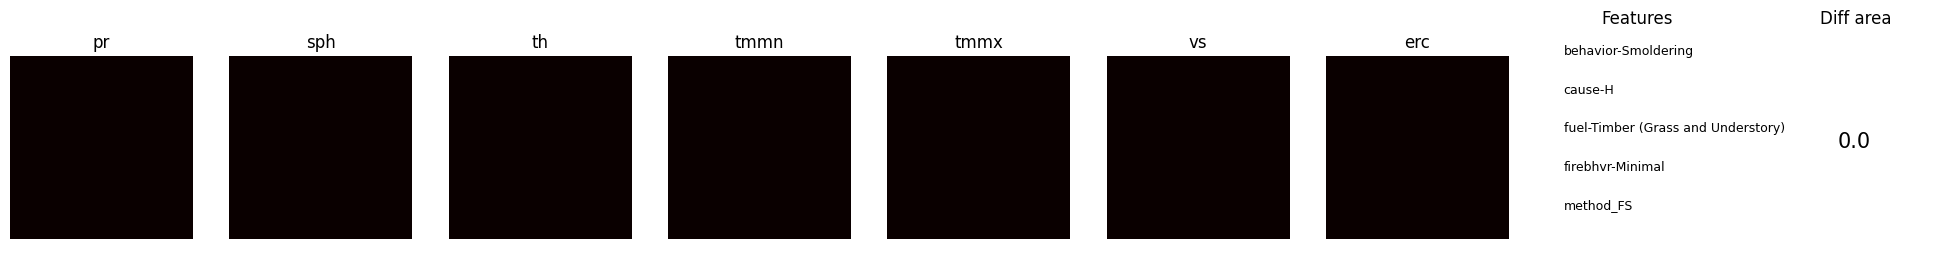

Report index: 24, fire id: 2015_2714466_BOLGEN CREEK


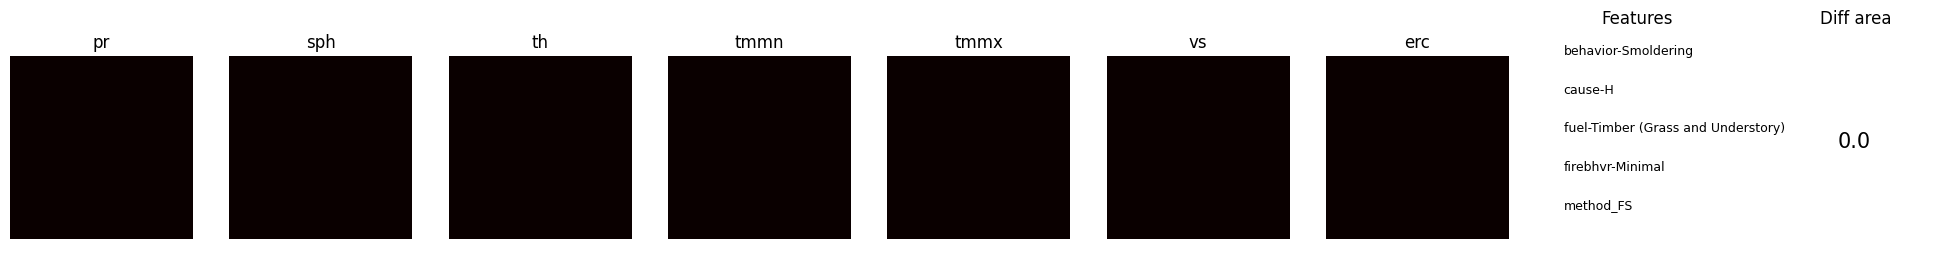

Report index: 25, fire id: 2015_2714666_SOUTH FORK KUSKOKWIM


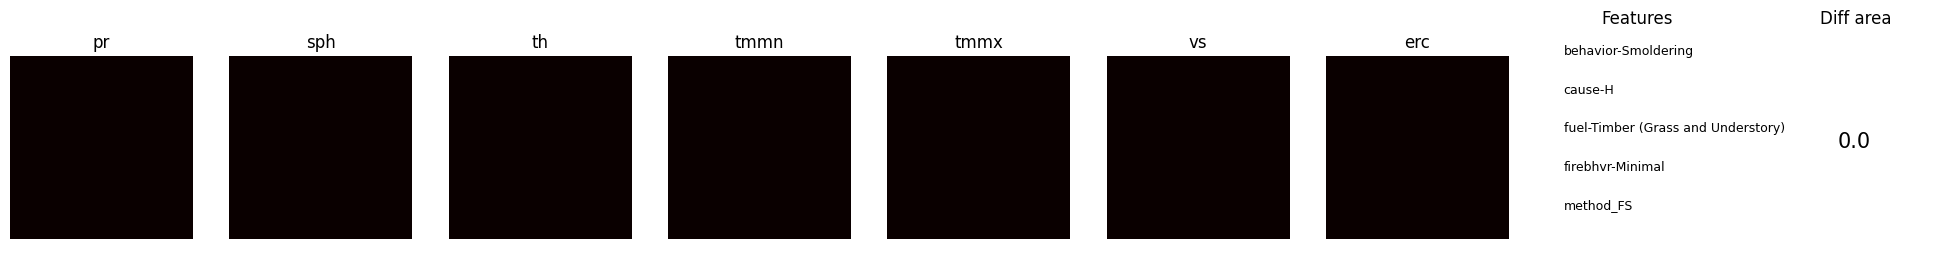

Report index: 26, fire id: 2015_2714724_DANIEL ROAD


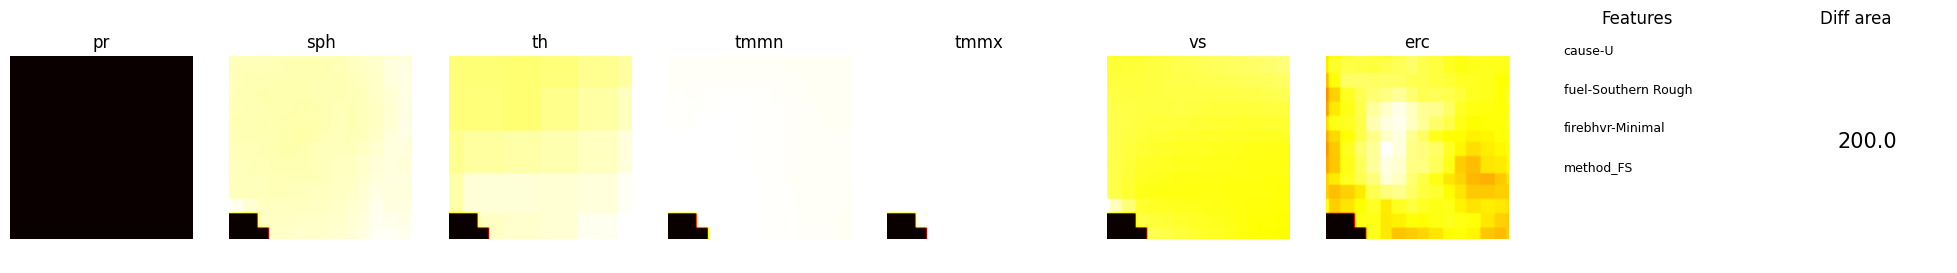

Report index: 27, fire id: 2015_2714724_DANIEL ROAD


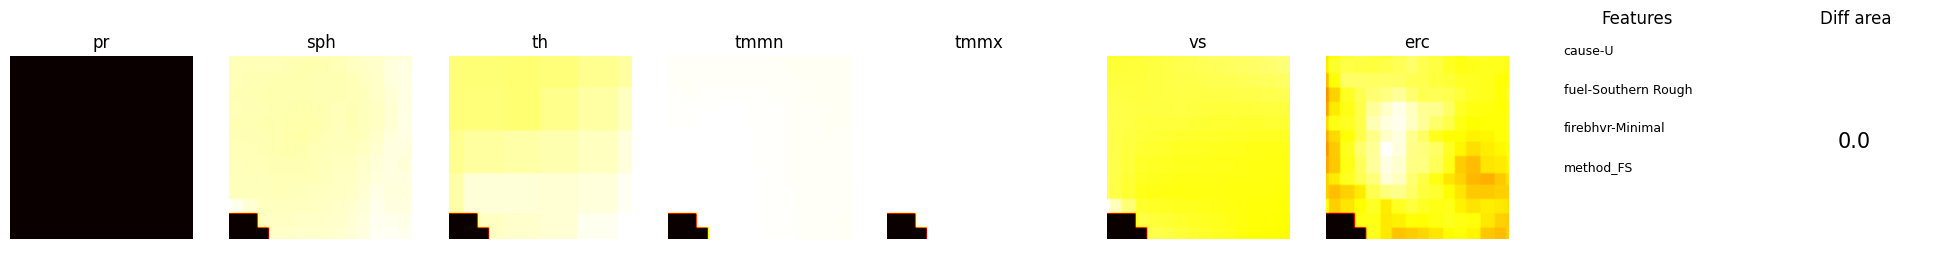

Report index: 28, fire id: 2015_2714724_DANIEL ROAD


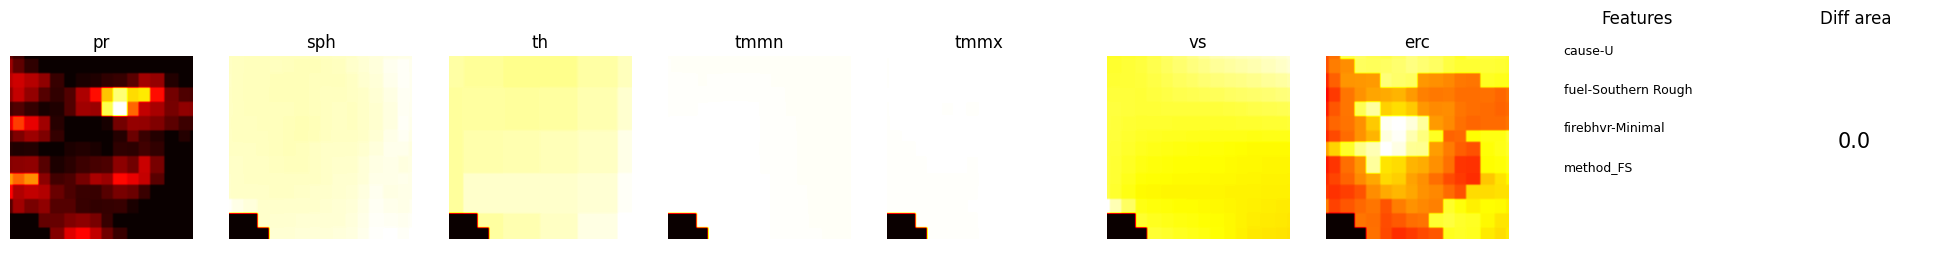

Report index: 29, fire id: 2015_2714724_DANIEL ROAD


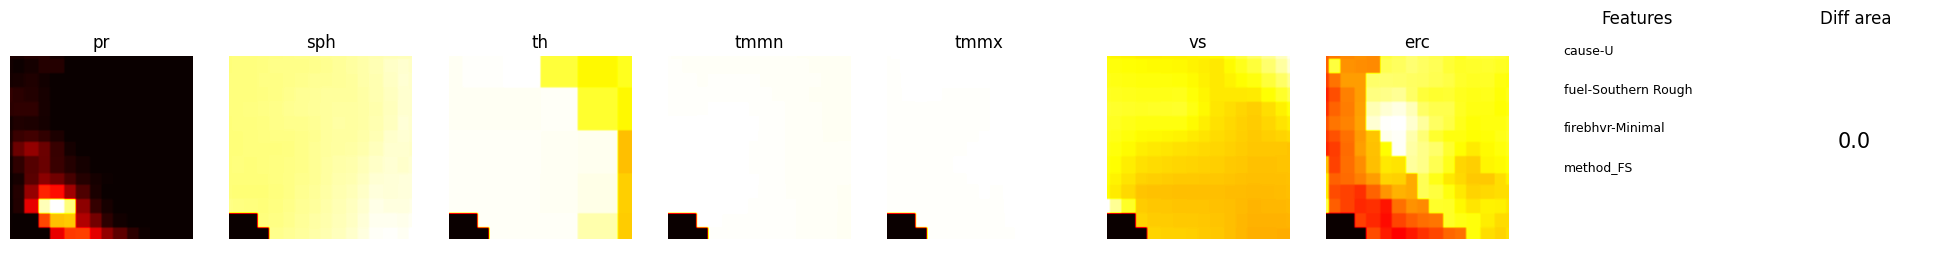

Report index: 30, fire id: 2015_2714724_DANIEL ROAD


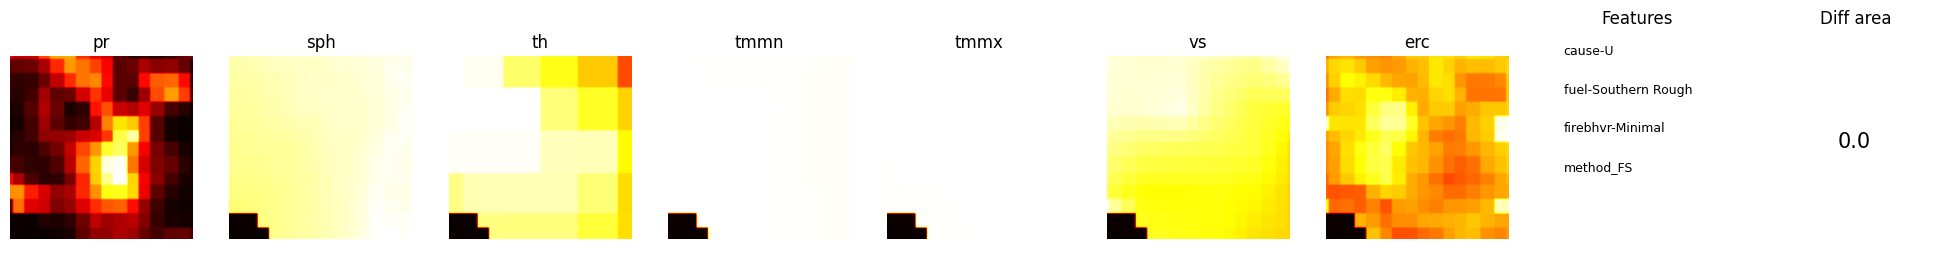

Report index: 31, fire id: 2015_2714807_HILLBILLY


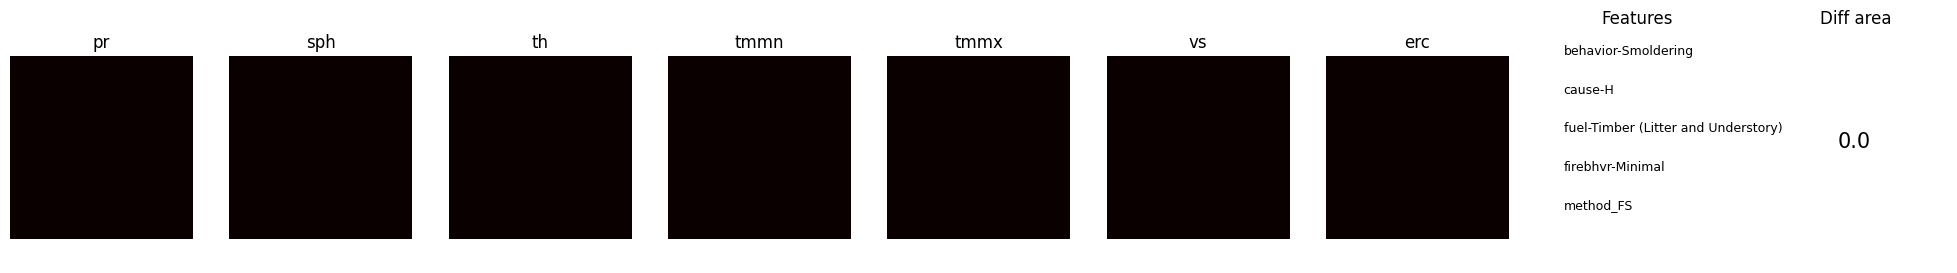

Report index: 32, fire id: 2015_2714807_HILLBILLY


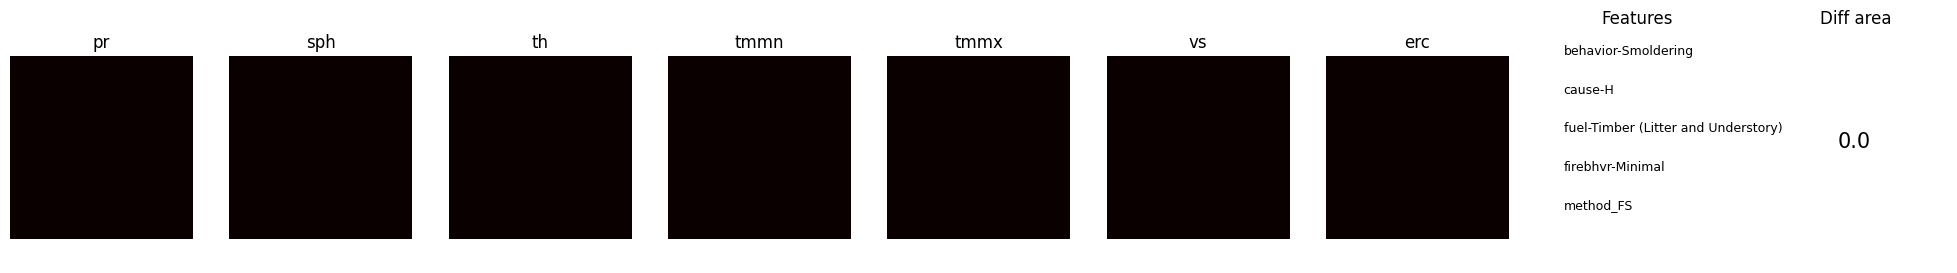

Report index: 33, fire id: 2015_2714994_WOLF MOUNTAIN


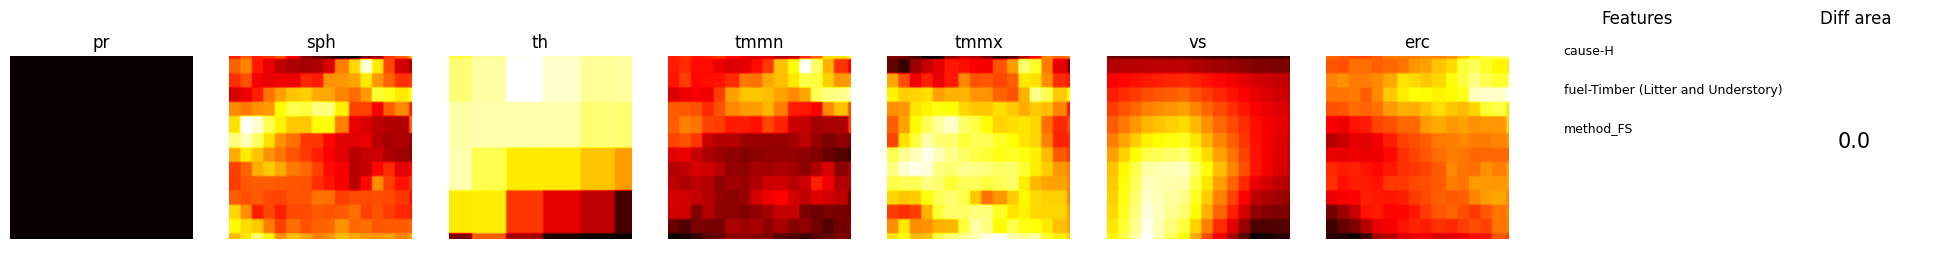

Report index: 34, fire id: 2015_2714994_WOLF MOUNTAIN


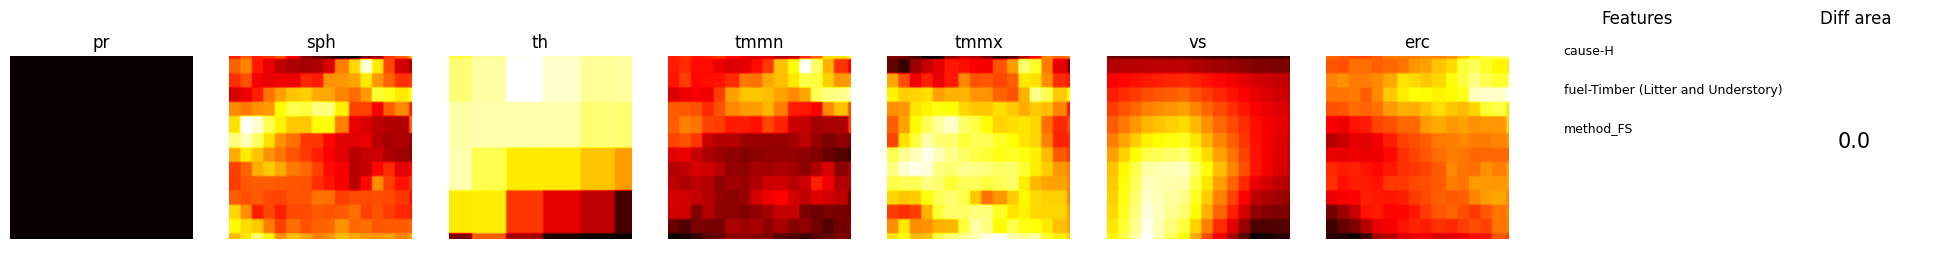

Report index: 35, fire id: 2015_2714994_WOLF MOUNTAIN


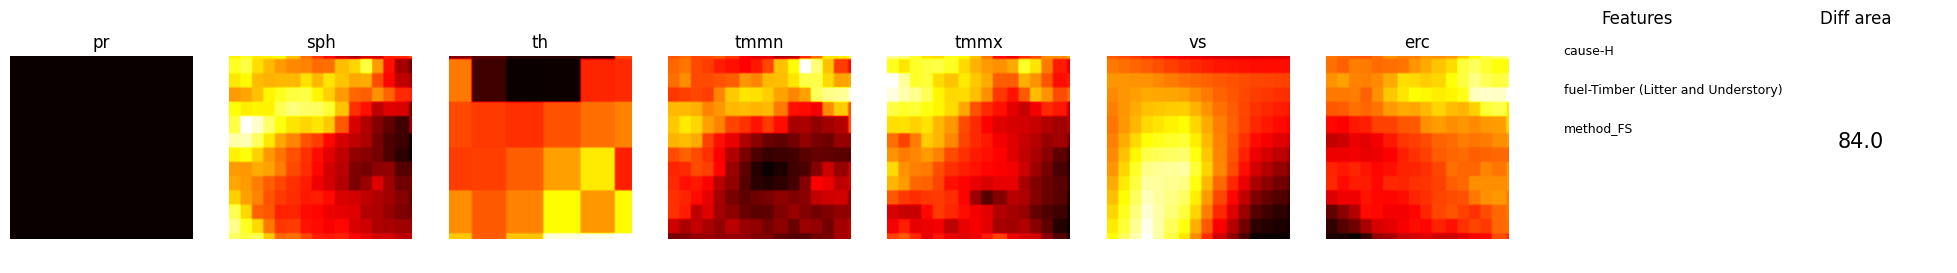

Report index: 36, fire id: 2015_2715062_COAL CREEK FIRE


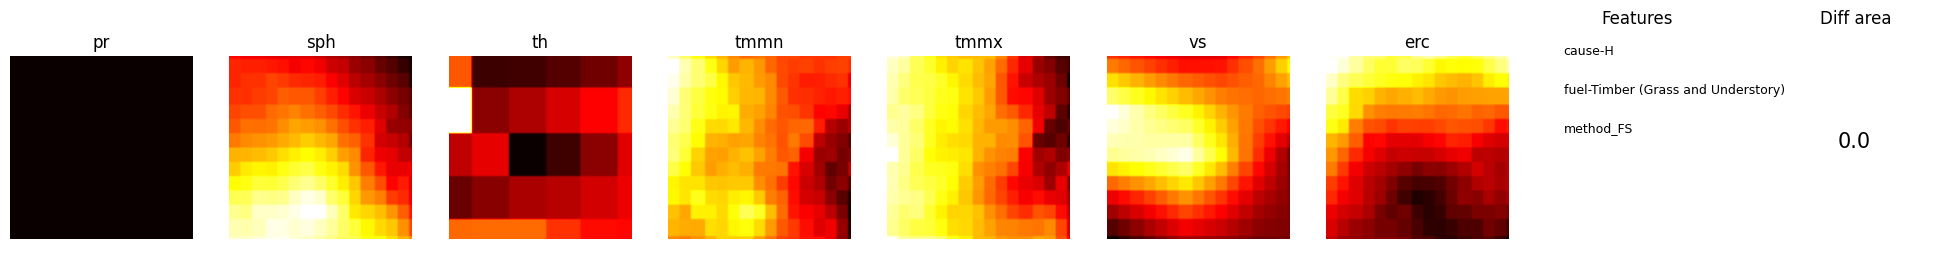

Report index: 37, fire id: 2015_2715110_WILSON SPRING ROAD


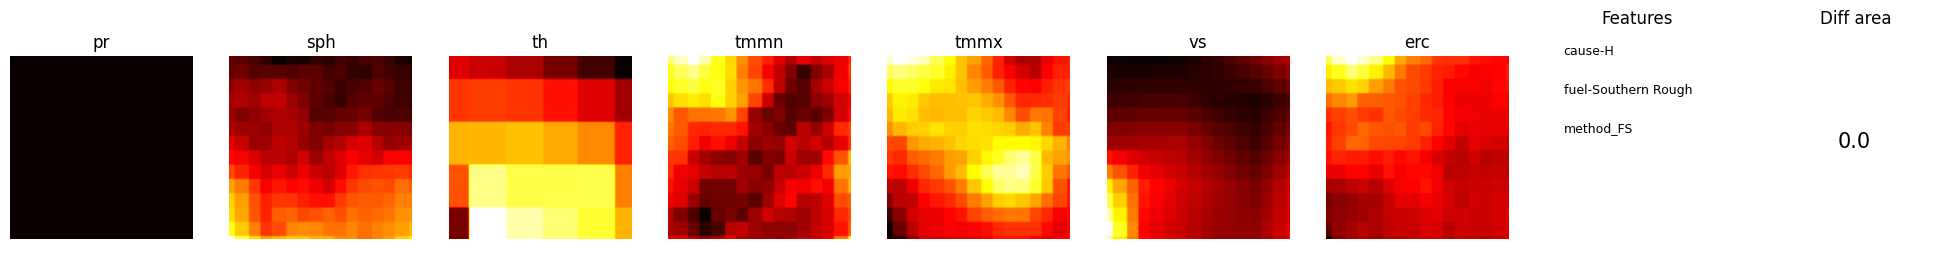

Report index: 38, fire id: 2015_2715110_WILSON SPRING ROAD


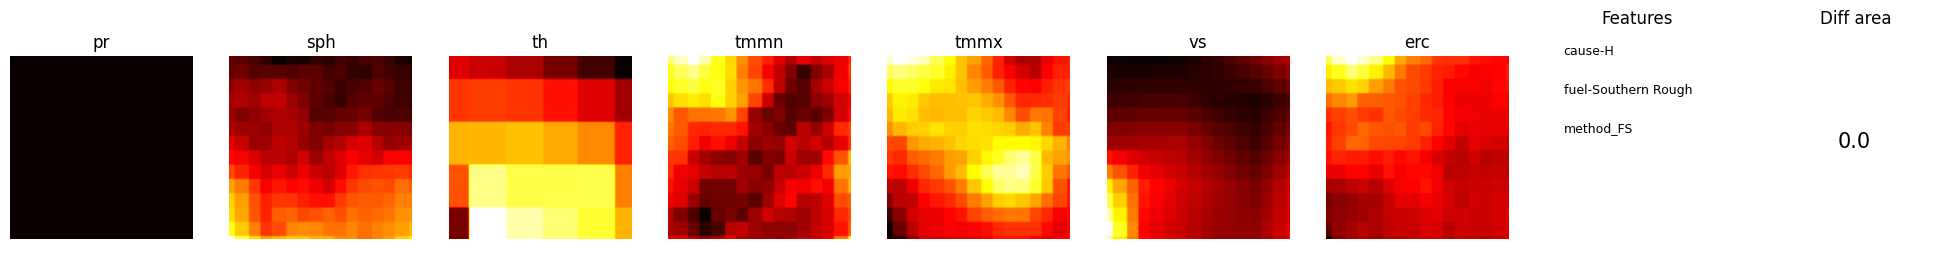

Report index: 39, fire id: 2015_2715373_BLAZO


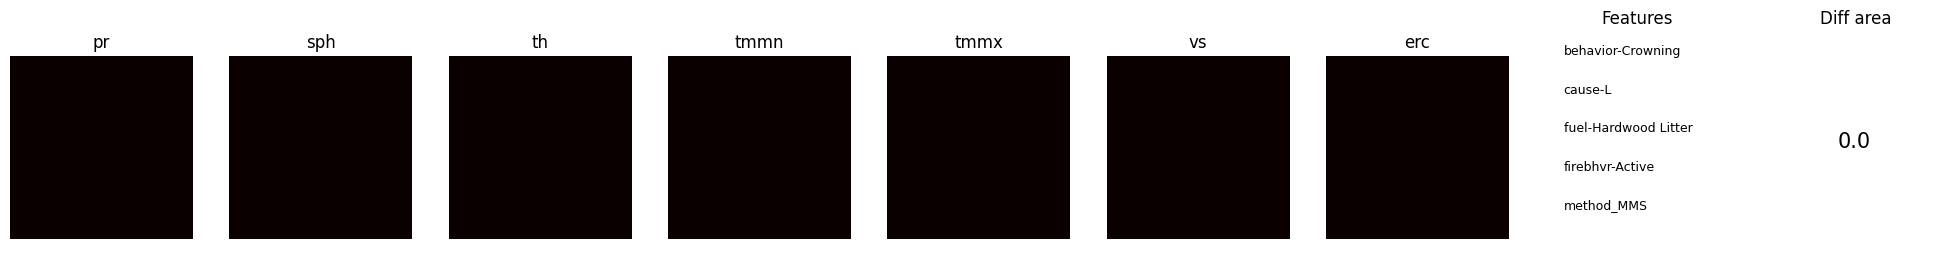

Report index: 40, fire id: 2015_2715425_WILLOW CREEK


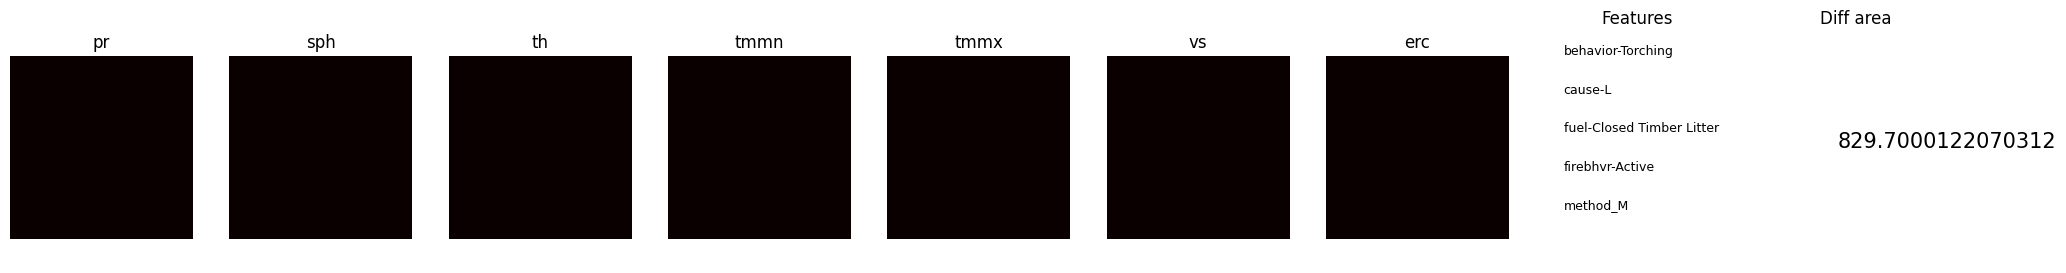

Report index: 41, fire id: 2015_2715425_WILLOW CREEK


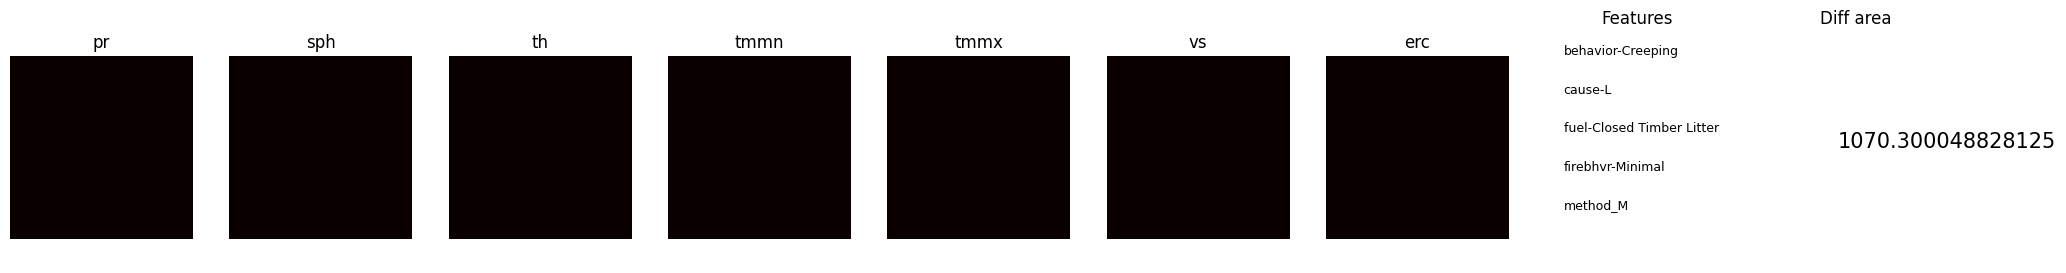

Report index: 42, fire id: 2015_2715425_WILLOW CREEK


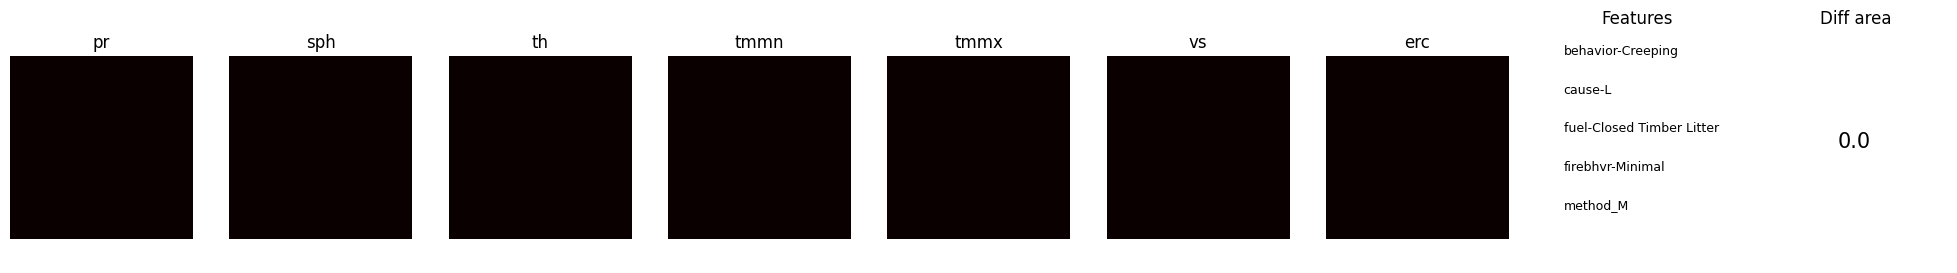

Report index: 43, fire id: 2015_2715527_GRAVES CREEK


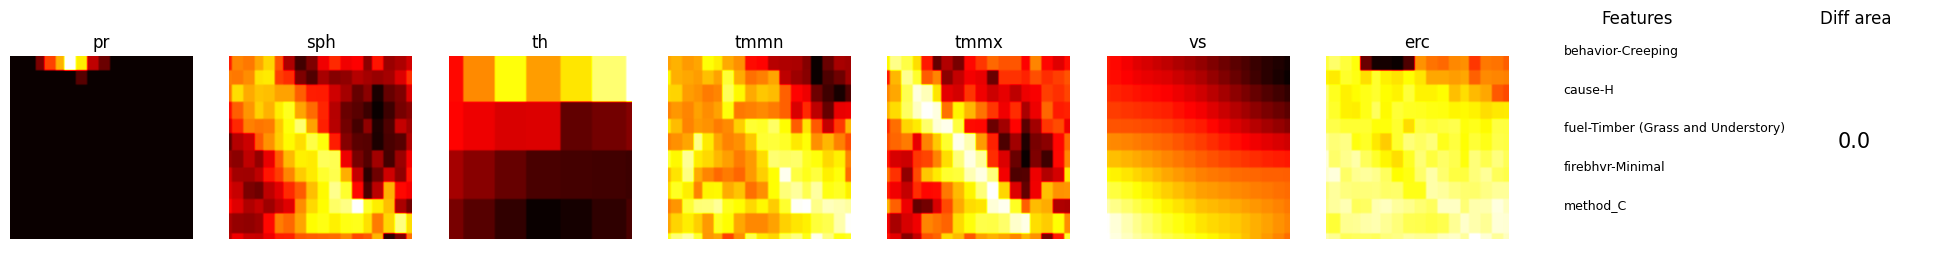

Report index: 44, fire id: 2015_2715527_GRAVES CREEK


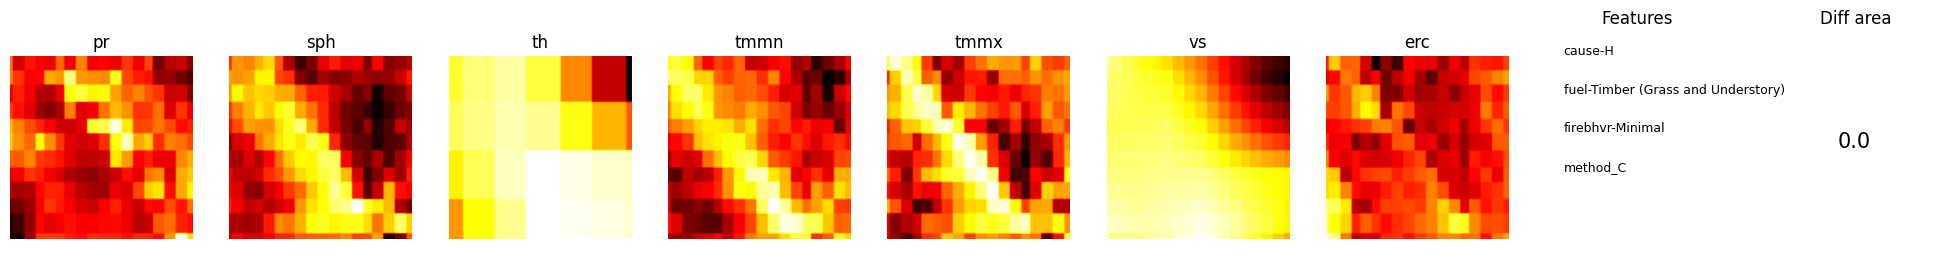

Report index: 45, fire id: 2015_2715639_WHITETAIL


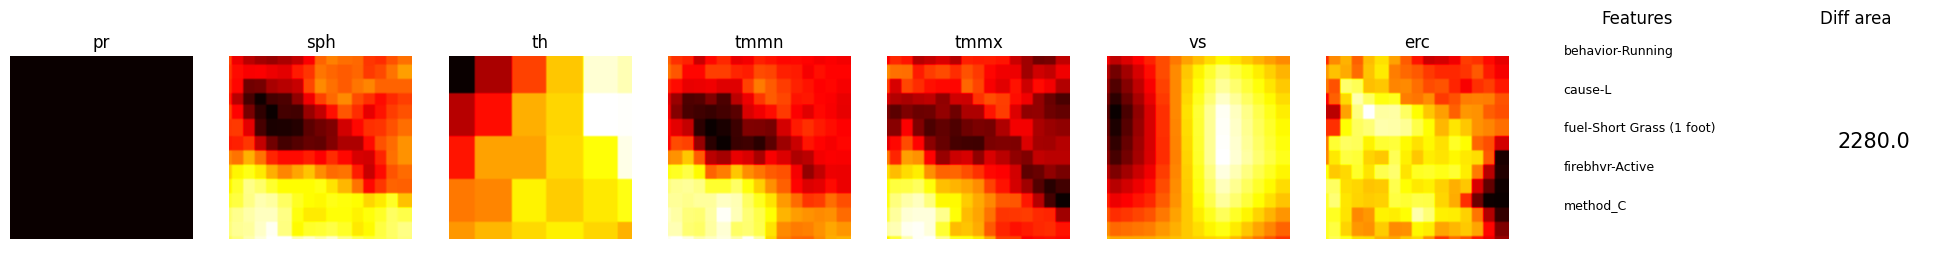

Report index: 46, fire id: 2015_2715639_WHITETAIL


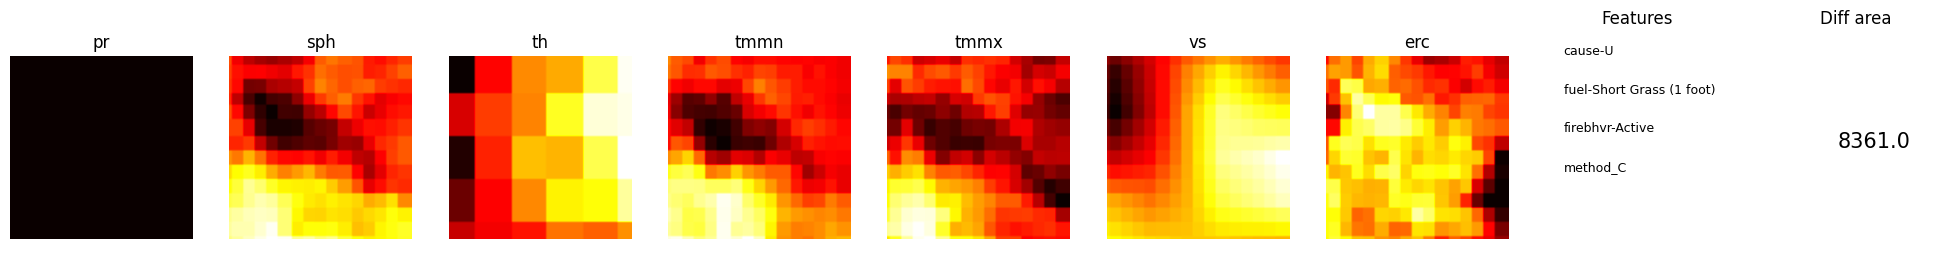

Report index: 47, fire id: 2015_2715639_WHITETAIL


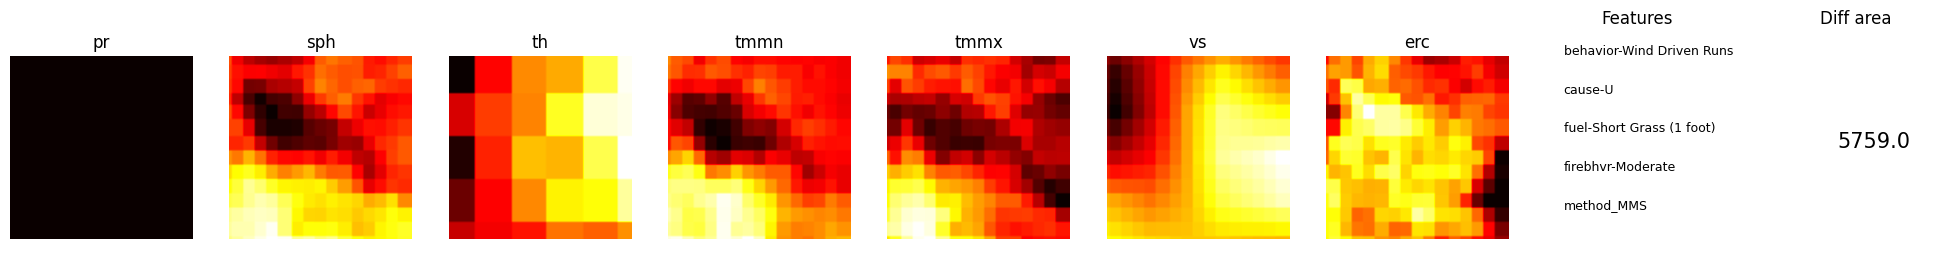

Report index: 48, fire id: 2015_2715639_WHITETAIL


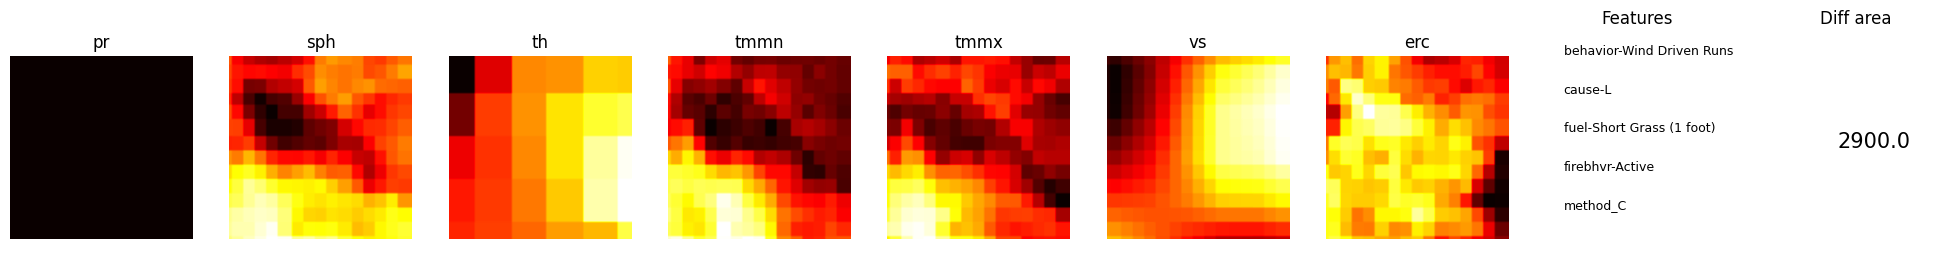

Report index: 49, fire id: 2015_2715639_WHITETAIL


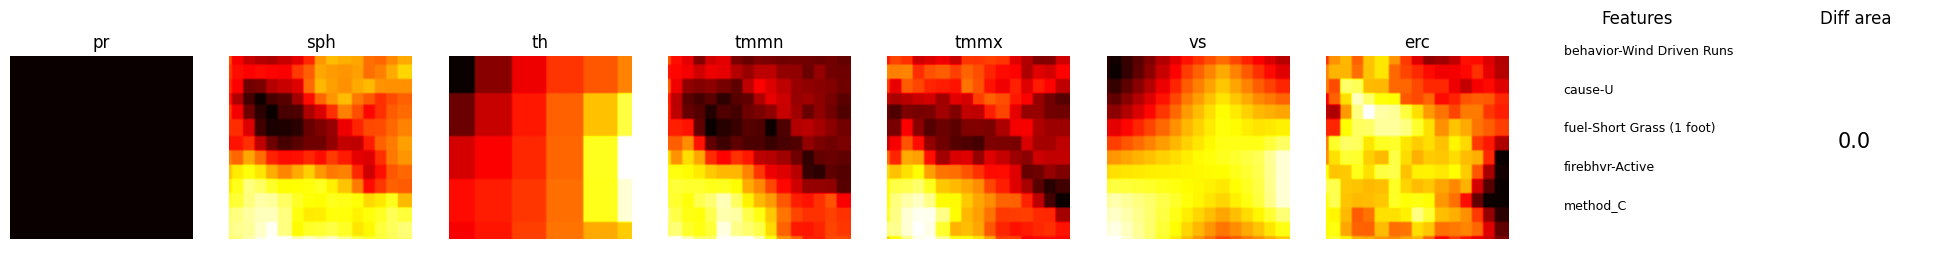

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

feature_names = list(fire.index[3:-8])

def visualize_dataset_item(dataset, layer_names, feature_names, idx):
    features, images_tensor, target = dataset[idx]

    images_np = images_tensor.numpy()

    fig, axs = plt.subplots(1, 9, figsize=(25, 3))  # 7 for the images, 1 for the features

    # images
    for i in range(images_np.shape[0]):
        axs[i].imshow(images_np[i], cmap=plt.get_cmap('hot'))
        axs[i].set_title(layer_names[i])
        axs[i].axis('off')



    # one hot features
    active_features = [feat for i, feat in enumerate(feature_names) if features[i]>0.1]
    for i, feature in enumerate(active_features):
        axs[7].text(0.1, 0.9-i*1/6, feature, fontsize=9)
        axs[7].axis('off')
        axs[7].set_title('Features')

    axs[8].text(0.4, 0.5, target.item(), fontsize=15)
    axs[8].axis('off')
    axs[8].set_title('Diff area')
    plt.show()


for i in range(50):
  print(f"Report index: {i}, fire id: {df.iloc[i].loc['id']}")
  visualize_dataset_item(dataset, layers, feature_names, i)


## Prediction

Largest problem for now:
* images problems: extreme values ? (=> clip), empty values?, weird values?
* feature problems: lots of features, empty for next report
* target problem:

In [ ]:
import torch.nn as nn
from torchvision import models

class EfficientNetB0_FireDataset(nn.Module):
    def __init__(self, num_features):
        super(EfficientNetB0_FireDataset, self).__init__()
        self.efficientnet = models.efficientnet_b0(pretrained=True)

        original_conv = self.efficientnet.features[0][0]

        # 7 channels
        self.efficientnet.features[0][0] = nn.Conv2d(
                                                      7,
                                                      original_conv.out_channels,
                                                      kernel_size=original_conv.kernel_size,
                                                      stride=original_conv.stride,
                                                      padding=original_conv.padding,
                                                      bias=original_conv.bias
                                                     )

        #for param in self.efficientnet.parameters():
        #    param.requires_grad = False

        num_ftrs = self.efficientnet.classifier[1].in_features
        self.efficientnet.classifier = nn.Linear(num_ftrs, 128)

        self.tab_features = nn.Sequential(
            nn.Linear(num_features, 16),
            nn.ReLU(),
            nn.Linear(16, 4),
            nn.ReLU()
        )
        self.final_layer = nn.Linear(128 + 4, 1)

    def forward(self, images, features):
        x1 = self.efficientnet(images)
        x2 = self.tab_features(features)
        x = torch.cat((x1, x2), dim=1)
        x = self.final_layer(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EfficientNetB0_FireDataset(num_features=dataset.number_features).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 29.2MB/s]


In [ ]:
!pip install torchviz

In [ ]:
!pip install torchsummary


In [ ]:
from torchviz import make_dot
train_loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=4)
for features, images, targets in train_loader:
      images, features, targets = images.to(device), features.to(device), targets.to(device)
      outputs = model(images, features)
      graph = make_dot(outputs, params=dict(list(model.named_parameters()) + [('images', images), ('features', features)]))
      break
graph.render('model_schema', format='png')


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


'model_schema.png'

In [ ]:
dataset

In [ ]:
from torch.utils.data import DataLoader, Subset

batch_size = 16
train_loader = DataLoader(Subset(dataset, range(3821)), batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(Subset(dataset, range(3821, len(dataset))), batch_size=batch_size,  num_workers=4)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
from tqdm import tqdm
num_epochs = 100
for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0
    for features, images, targets in tqdm(train_loader):
        images, features, targets = images.to(device), features.to(device), targets.to(device)
        optimizer.zero_grad()

        outputs = model(images, features)
        loss = criterion(outputs, targets.unsqueeze(1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')

    model.eval()
    eval_loss = 0.0
    for features, images, targets in tqdm(val_loader):
        images, features, targets = images.to(device), features.to(device), targets.to(device)
        outputs = model(images, features)
        loss = criterion(outputs, targets.unsqueeze(1))
        eval_loss += loss
    print(f'Validation Loss: {eval_loss/len(val_loader)}')

  0%|          | 0/239 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()

100%|██████████| 239/239 [00:14<00:00, 17.30it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 239/239 [00:14<00:00, 16.38it/s]


Epoch 1, Loss: 34596802.65172778



  1%|          | 1/100 [00:16<27:26, 16.63s/it]

Validation Loss: 44530784.0



100%|██████████| 239/239 [00:13<00:00, 18.25it/s]


Epoch 2, Loss: 33620620.303216524



  2%|▏         | 2/100 [00:31<25:33, 15.64s/it]

Validation Loss: 44436160.0



100%|██████████| 239/239 [00:14<00:00, 16.81it/s]


Epoch 3, Loss: 33614069.89301124



  3%|▎         | 3/100 [00:47<25:32, 15.80s/it]

Validation Loss: 44337060.0



100%|██████████| 239/239 [00:14<00:00, 16.93it/s]


Epoch 4, Loss: 33474540.460872125



  4%|▍         | 4/100 [01:04<25:46, 16.11s/it]

Validation Loss: 44257412.0



100%|██████████| 239/239 [00:13<00:00, 18.01it/s]


Epoch 5, Loss: 33466630.32126046



  5%|▌         | 5/100 [01:19<24:54, 15.73s/it]

Validation Loss: 44116544.0



100%|██████████| 239/239 [00:16<00:00, 14.42it/s]


Epoch 6, Loss: 33274741.307662133



  6%|▌         | 6/100 [01:37<26:04, 16.64s/it]

Validation Loss: 43850516.0



100%|██████████| 239/239 [00:13<00:00, 17.55it/s]


Epoch 7, Loss: 33342243.447110355



  7%|▋         | 7/100 [01:53<25:26, 16.41s/it]

Validation Loss: 44133436.0



100%|██████████| 239/239 [00:13<00:00, 17.22it/s]


Epoch 8, Loss: 33177879.671940375



  8%|▊         | 8/100 [02:09<24:48, 16.18s/it]

Validation Loss: 43799076.0



100%|██████████| 239/239 [00:13<00:00, 17.59it/s]


Epoch 9, Loss: 33124814.106629185



  9%|▉         | 9/100 [02:24<24:12, 15.96s/it]

Validation Loss: 44323728.0



100%|██████████| 239/239 [00:13<00:00, 17.46it/s]


Epoch 10, Loss: 33028061.34433839



 10%|█         | 10/100 [02:40<23:43, 15.81s/it]

Validation Loss: 44177288.0



100%|██████████| 239/239 [00:13<00:00, 17.65it/s]


Epoch 11, Loss: 33330265.056027718



 11%|█         | 11/100 [02:56<23:33, 15.88s/it]

Validation Loss: 43843932.0



100%|██████████| 239/239 [00:13<00:00, 17.27it/s]


Epoch 12, Loss: 33253696.63716004



 12%|█▏        | 12/100 [03:12<23:14, 15.85s/it]

Validation Loss: 43701176.0



100%|██████████| 239/239 [00:13<00:00, 17.34it/s]


Epoch 13, Loss: 33211894.976464435



 13%|█▎        | 13/100 [03:28<23:06, 15.94s/it]

Validation Loss: 43737644.0



100%|██████████| 239/239 [00:13<00:00, 17.15it/s]


Epoch 14, Loss: 33168177.842377093



 14%|█▍        | 14/100 [03:43<22:48, 15.91s/it]

Validation Loss: 43327844.0



100%|██████████| 239/239 [00:14<00:00, 16.42it/s]


Epoch 15, Loss: 33170386.027915794



 15%|█▌        | 15/100 [04:00<22:51, 16.14s/it]

Validation Loss: 44094060.0



100%|██████████| 239/239 [00:14<00:00, 16.97it/s]


Epoch 16, Loss: 33124328.109048117



 16%|█▌        | 16/100 [04:16<22:31, 16.09s/it]

Validation Loss: 43723736.0



100%|██████████| 239/239 [00:14<00:00, 16.84it/s]


Epoch 17, Loss: 33088455.760591004



 17%|█▋        | 17/100 [04:32<22:15, 16.09s/it]

Validation Loss: 43762820.0



100%|██████████| 239/239 [00:14<00:00, 16.62it/s]


Epoch 18, Loss: 33061619.085839435



 18%|█▊        | 18/100 [04:49<22:21, 16.36s/it]

Validation Loss: 44608080.0



100%|██████████| 239/239 [00:15<00:00, 15.53it/s]


Epoch 19, Loss: 32936366.059231173



 19%|█▉        | 19/100 [05:07<22:27, 16.64s/it]

Validation Loss: 43956168.0



100%|██████████| 239/239 [00:14<00:00, 16.90it/s]


Epoch 20, Loss: 33256144.49810408



 20%|██        | 20/100 [05:23<21:56, 16.46s/it]

Validation Loss: 43480600.0



100%|██████████| 239/239 [00:14<00:00, 16.76it/s]


Epoch 21, Loss: 33012006.461623956



 21%|██        | 21/100 [05:39<21:38, 16.44s/it]

Validation Loss: 44073164.0



100%|██████████| 239/239 [00:14<00:00, 16.11it/s]


Epoch 22, Loss: 32947399.201882847



 22%|██▏       | 22/100 [05:56<21:30, 16.54s/it]

Validation Loss: 43651808.0



100%|██████████| 239/239 [00:14<00:00, 16.77it/s]


Epoch 23, Loss: 33102474.229079496



 23%|██▎       | 23/100 [06:12<21:04, 16.42s/it]

Validation Loss: 43897092.0



100%|██████████| 239/239 [00:14<00:00, 16.68it/s]


Epoch 24, Loss: 32987540.610944036



 24%|██▍       | 24/100 [06:28<20:44, 16.38s/it]

Validation Loss: 43741504.0



100%|██████████| 239/239 [00:15<00:00, 15.76it/s]


Epoch 25, Loss: 33026374.82224111



 25%|██▌       | 25/100 [06:45<20:46, 16.61s/it]

Validation Loss: 43846716.0



100%|██████████| 239/239 [00:14<00:00, 16.60it/s]


Epoch 26, Loss: 32848324.3261637



 26%|██▌       | 26/100 [07:02<20:24, 16.54s/it]

Validation Loss: 43738348.0



100%|██████████| 239/239 [00:14<00:00, 16.65it/s]


Epoch 27, Loss: 32823707.595907427



 27%|██▋       | 27/100 [07:18<20:05, 16.52s/it]

Validation Loss: 43725444.0



100%|██████████| 239/239 [00:15<00:00, 15.81it/s]


Epoch 28, Loss: 32806392.18540795



 28%|██▊       | 28/100 [07:35<20:06, 16.76s/it]

Validation Loss: 43897060.0



100%|██████████| 239/239 [00:14<00:00, 16.54it/s]


Epoch 29, Loss: 32753377.403504185



 29%|██▉       | 29/100 [07:52<19:42, 16.65s/it]

Validation Loss: 43899504.0



100%|██████████| 239/239 [00:14<00:00, 16.20it/s]


Epoch 30, Loss: 32997969.02915795



 30%|███       | 30/100 [08:09<19:26, 16.67s/it]

Validation Loss: 43840216.0



100%|██████████| 239/239 [00:15<00:00, 15.74it/s]


Epoch 31, Loss: 32848579.89827406



 31%|███       | 31/100 [08:26<19:27, 16.92s/it]

Validation Loss: 44262876.0



100%|██████████| 239/239 [00:14<00:00, 16.34it/s]


Epoch 32, Loss: 32866755.664160565



 32%|███▏      | 32/100 [08:43<19:04, 16.83s/it]

Validation Loss: 44963492.0



100%|██████████| 239/239 [00:14<00:00, 16.38it/s]


Epoch 33, Loss: 32812692.492677823



 33%|███▎      | 33/100 [08:59<18:41, 16.74s/it]

Validation Loss: 43857904.0



100%|██████████| 239/239 [00:15<00:00, 15.91it/s]


Epoch 34, Loss: 32671855.63284519



 34%|███▍      | 34/100 [09:17<18:41, 16.99s/it]

Validation Loss: 43914332.0



100%|██████████| 239/239 [00:15<00:00, 15.35it/s]


Epoch 35, Loss: 32795035.81707636



 35%|███▌      | 35/100 [09:35<18:38, 17.20s/it]

Validation Loss: 43991516.0



100%|██████████| 239/239 [00:14<00:00, 16.29it/s]


Epoch 36, Loss: 32681979.9885591



 36%|███▌      | 36/100 [09:51<18:10, 17.04s/it]

Validation Loss: 43908728.0



100%|██████████| 239/239 [00:15<00:00, 15.52it/s]


Epoch 37, Loss: 32422242.139415532



 37%|███▋      | 37/100 [10:09<18:01, 17.17s/it]

Validation Loss: 44298668.0



100%|██████████| 239/239 [00:14<00:00, 16.19it/s]


Epoch 38, Loss: 32691985.191291843



 38%|███▊      | 38/100 [10:26<17:44, 17.17s/it]

Validation Loss: 44447384.0



100%|██████████| 239/239 [00:14<00:00, 16.24it/s]


Epoch 39, Loss: 32395240.331982218



 39%|███▉      | 39/100 [10:43<17:21, 17.07s/it]

Validation Loss: 44185820.0



100%|██████████| 239/239 [00:15<00:00, 15.47it/s]


Epoch 40, Loss: 32511470.996927302



 40%|████      | 40/100 [11:00<17:11, 17.19s/it]

Validation Loss: 44341476.0



100%|██████████| 239/239 [00:14<00:00, 16.18it/s]


Epoch 41, Loss: 32583315.660564855



 41%|████      | 41/100 [11:17<16:46, 17.06s/it]

Validation Loss: 44226412.0



100%|██████████| 239/239 [00:14<00:00, 16.08it/s]


Epoch 42, Loss: 32480714.192403242



 42%|████▏     | 42/100 [11:34<16:34, 17.15s/it]

Validation Loss: 44466872.0



100%|██████████| 239/239 [00:15<00:00, 15.69it/s]


Epoch 43, Loss: 32228215.513075314



 43%|████▎     | 43/100 [11:52<16:20, 17.20s/it]

Validation Loss: 44830048.0



100%|██████████| 239/239 [00:14<00:00, 16.02it/s]


Epoch 44, Loss: 32500486.259152718



 44%|████▍     | 44/100 [12:08<15:57, 17.10s/it]

Validation Loss: 44379244.0



100%|██████████| 239/239 [00:14<00:00, 16.22it/s]


Epoch 45, Loss: 32127750.073614016



 45%|████▌     | 45/100 [12:26<15:47, 17.23s/it]

Validation Loss: 44385588.0



100%|██████████| 239/239 [00:15<00:00, 15.88it/s]


Epoch 46, Loss: 32235024.5083682



 46%|████▌     | 46/100 [12:43<15:29, 17.20s/it]

Validation Loss: 44551244.0



100%|██████████| 239/239 [00:15<00:00, 15.89it/s]


Epoch 47, Loss: 32073308.69952929



 47%|████▋     | 47/100 [13:00<15:09, 17.16s/it]

Validation Loss: 44551592.0



100%|██████████| 239/239 [00:15<00:00, 15.30it/s]


Epoch 48, Loss: 32144736.477771968



 48%|████▊     | 48/100 [13:18<15:07, 17.45s/it]

Validation Loss: 44355252.0



100%|██████████| 239/239 [00:15<00:00, 15.76it/s]


Epoch 49, Loss: 32265821.811061714



 49%|████▉     | 49/100 [13:36<14:46, 17.39s/it]

Validation Loss: 44590308.0



100%|██████████| 239/239 [00:16<00:00, 14.90it/s]


Epoch 50, Loss: 31990187.89271705



 50%|█████     | 50/100 [13:54<14:45, 17.70s/it]

Validation Loss: 46169496.0



100%|██████████| 239/239 [00:15<00:00, 15.07it/s]


Epoch 51, Loss: 31999469.253791843



 51%|█████     | 51/100 [14:12<14:30, 17.77s/it]

Validation Loss: 45033360.0



100%|██████████| 239/239 [00:14<00:00, 15.94it/s]


Epoch 52, Loss: 31850667.496927302



 52%|█████▏    | 52/100 [14:29<14:02, 17.55s/it]

Validation Loss: 45429164.0



100%|██████████| 239/239 [00:15<00:00, 15.33it/s]


Epoch 53, Loss: 31869567.280988492



 53%|█████▎    | 53/100 [14:47<13:55, 17.79s/it]

Validation Loss: 45608912.0



100%|██████████| 239/239 [00:15<00:00, 15.74it/s]


Epoch 54, Loss: 31836930.434492677



 54%|█████▍    | 54/100 [15:05<13:30, 17.62s/it]

Validation Loss: 44806900.0



100%|██████████| 239/239 [00:15<00:00, 15.62it/s]


Epoch 55, Loss: 31691440.54609048



 55%|█████▌    | 55/100 [15:22<13:09, 17.55s/it]

Validation Loss: 45798136.0



100%|██████████| 239/239 [00:16<00:00, 14.81it/s]


Epoch 56, Loss: 31781721.073614016



 56%|█████▌    | 56/100 [15:40<13:00, 17.74s/it]

Validation Loss: 45654580.0



100%|██████████| 239/239 [00:15<00:00, 15.86it/s]


Epoch 57, Loss: 31804026.35865586



 57%|█████▋    | 57/100 [15:57<12:34, 17.54s/it]

Validation Loss: 45615424.0



100%|██████████| 239/239 [00:15<00:00, 15.36it/s]


Epoch 58, Loss: 31968466.673149843



 58%|█████▊    | 58/100 [16:15<12:25, 17.75s/it]

Validation Loss: 44803972.0



100%|██████████| 239/239 [00:15<00:00, 15.02it/s]


Epoch 59, Loss: 31694371.792625524



 59%|█████▉    | 59/100 [16:33<12:10, 17.82s/it]

Validation Loss: 45269028.0



100%|██████████| 239/239 [00:15<00:00, 15.41it/s]


Epoch 60, Loss: 31797923.65533473



 60%|██████    | 60/100 [16:51<11:50, 17.77s/it]

Validation Loss: 45536472.0



100%|██████████| 239/239 [00:16<00:00, 14.67it/s]


Epoch 61, Loss: 31623438.454432532



 61%|██████    | 61/100 [17:10<11:41, 17.98s/it]

Validation Loss: 45470508.0



100%|██████████| 239/239 [00:15<00:00, 15.57it/s]


Epoch 62, Loss: 31436698.605517782



 62%|██████▏   | 62/100 [17:27<11:18, 17.84s/it]

Validation Loss: 45291400.0



100%|██████████| 239/239 [00:15<00:00, 15.24it/s]


Epoch 63, Loss: 31365228.979144875



 63%|██████▎   | 63/100 [17:46<11:09, 18.11s/it]

Validation Loss: 47068880.0



100%|██████████| 239/239 [00:16<00:00, 14.63it/s]


Epoch 64, Loss: 31509073.69416841



 64%|██████▍   | 64/100 [18:05<11:05, 18.47s/it]

Validation Loss: 45594080.0



100%|██████████| 239/239 [00:15<00:00, 15.37it/s]


Epoch 65, Loss: 31419478.364801254



 65%|██████▌   | 65/100 [18:23<10:41, 18.32s/it]

Validation Loss: 45214304.0



100%|██████████| 239/239 [00:16<00:00, 14.44it/s]


Epoch 66, Loss: 31389147.439297855



 66%|██████▌   | 66/100 [18:42<10:27, 18.44s/it]

Validation Loss: 45256160.0



100%|██████████| 239/239 [00:16<00:00, 14.89it/s]


Epoch 67, Loss: 31356917.836231694



 67%|██████▋   | 67/100 [19:00<10:07, 18.39s/it]

Validation Loss: 45997408.0



100%|██████████| 239/239 [00:16<00:00, 14.25it/s]


Epoch 68, Loss: 31311218.39212866



 68%|██████▊   | 68/100 [19:19<09:53, 18.55s/it]

Validation Loss: 45248888.0



100%|██████████| 239/239 [00:15<00:00, 15.36it/s]


Epoch 69, Loss: 31286805.746273536



 69%|██████▉   | 69/100 [19:37<09:26, 18.28s/it]

Validation Loss: 46101508.0



100%|██████████| 239/239 [00:15<00:00, 15.15it/s]


Epoch 70, Loss: 31484270.025235355



 70%|███████   | 70/100 [19:55<09:13, 18.45s/it]

Validation Loss: 45433836.0



100%|██████████| 239/239 [00:15<00:00, 15.43it/s]


Epoch 71, Loss: 31390573.260591004



 71%|███████   | 71/100 [20:13<08:46, 18.16s/it]

Validation Loss: 45208320.0



100%|██████████| 239/239 [00:15<00:00, 15.28it/s]


Epoch 72, Loss: 31174505.62349634



 72%|███████▏  | 72/100 [20:31<08:25, 18.06s/it]

Validation Loss: 45075236.0



100%|██████████| 239/239 [00:16<00:00, 14.54it/s]


Epoch 73, Loss: 30944657.521443516



 73%|███████▎  | 73/100 [20:49<08:12, 18.24s/it]

Validation Loss: 47502188.0



100%|██████████| 239/239 [00:15<00:00, 15.07it/s]


Epoch 74, Loss: 31347085.833420504



 74%|███████▍  | 74/100 [21:07<07:52, 18.19s/it]

Validation Loss: 46170972.0



100%|██████████| 239/239 [00:17<00:00, 13.85it/s]


Epoch 75, Loss: 31456646.68292364



 75%|███████▌  | 75/100 [21:28<07:48, 18.74s/it]

Validation Loss: 44781584.0



100%|██████████| 239/239 [00:16<00:00, 14.75it/s]


Epoch 76, Loss: 31183105.60303347



 76%|███████▌  | 76/100 [21:46<07:27, 18.66s/it]

Validation Loss: 46565904.0



100%|██████████| 239/239 [00:16<00:00, 14.66it/s]


Epoch 77, Loss: 31210106.35139906



 77%|███████▋  | 77/100 [22:05<07:13, 18.83s/it]

Validation Loss: 47131892.0



100%|██████████| 239/239 [00:16<00:00, 14.11it/s]


Epoch 78, Loss: 31478604.983721234



 78%|███████▊  | 78/100 [22:24<06:56, 18.92s/it]

Validation Loss: 45106392.0



100%|██████████| 239/239 [00:16<00:00, 14.87it/s]


Epoch 79, Loss: 31033246.325771444



 79%|███████▉  | 79/100 [22:43<06:33, 18.74s/it]

Validation Loss: 45336852.0



100%|██████████| 239/239 [00:16<00:00, 14.25it/s]


Epoch 80, Loss: 31128167.81400366



 80%|████████  | 80/100 [23:02<06:16, 18.85s/it]

Validation Loss: 45455660.0



100%|██████████| 239/239 [00:16<00:00, 14.90it/s]


Epoch 81, Loss: 31132339.4707113



 81%|████████  | 81/100 [23:20<05:54, 18.66s/it]

Validation Loss: 45680136.0



100%|██████████| 239/239 [00:15<00:00, 15.12it/s]


Epoch 82, Loss: 31012122.30792364



 82%|████████▏ | 82/100 [23:39<05:36, 18.70s/it]

Validation Loss: 45014500.0



100%|██████████| 239/239 [00:16<00:00, 14.43it/s]


Epoch 83, Loss: 31033722.68253138



 83%|████████▎ | 83/100 [23:58<05:18, 18.73s/it]

Validation Loss: 46674364.0



100%|██████████| 239/239 [00:15<00:00, 14.94it/s]


Epoch 84, Loss: 31048092.354733262



 84%|████████▍ | 84/100 [24:16<04:57, 18.60s/it]

Validation Loss: 47323196.0



100%|██████████| 239/239 [00:16<00:00, 14.33it/s]


Epoch 85, Loss: 31305980.96018567



 85%|████████▌ | 85/100 [24:35<04:40, 18.68s/it]

Validation Loss: 45296208.0



100%|██████████| 239/239 [00:16<00:00, 14.89it/s]


Epoch 86, Loss: 30968476.87382322



 86%|████████▌ | 86/100 [24:53<04:20, 18.58s/it]

Validation Loss: 46235396.0



100%|██████████| 239/239 [00:16<00:00, 14.35it/s]


Epoch 87, Loss: 30821121.475679915



 87%|████████▋ | 87/100 [25:12<04:03, 18.75s/it]

Validation Loss: 46479400.0



100%|██████████| 239/239 [00:16<00:00, 14.84it/s]


Epoch 88, Loss: 30923300.408276673



 88%|████████▊ | 88/100 [25:31<03:43, 18.64s/it]

Validation Loss: 46325324.0



100%|██████████| 239/239 [00:16<00:00, 14.52it/s]


Epoch 89, Loss: 31298476.73247908



 89%|████████▉ | 89/100 [25:50<03:28, 18.91s/it]

Validation Loss: 46264648.0



100%|██████████| 239/239 [00:16<00:00, 14.68it/s]


Epoch 90, Loss: 30867914.734701883



 90%|█████████ | 90/100 [26:09<03:09, 18.93s/it]

Validation Loss: 46386528.0



100%|██████████| 239/239 [00:16<00:00, 14.66it/s]


Epoch 91, Loss: 30968207.059688807



 91%|█████████ | 91/100 [26:28<02:50, 18.98s/it]

Validation Loss: 47780516.0



100%|██████████| 239/239 [00:17<00:00, 13.44it/s]


Epoch 92, Loss: 31399993.47672594



 92%|█████████▏| 92/100 [26:48<02:34, 19.30s/it]

Validation Loss: 44649224.0



100%|██████████| 239/239 [00:16<00:00, 14.60it/s]


Epoch 93, Loss: 30869437.630622383



 93%|█████████▎| 93/100 [27:07<02:14, 19.24s/it]

Validation Loss: 47105672.0



100%|██████████| 239/239 [00:16<00:00, 14.17it/s]


Epoch 94, Loss: 30831235.103556484



 94%|█████████▍| 94/100 [27:27<01:55, 19.21s/it]

Validation Loss: 46869140.0



100%|██████████| 239/239 [00:16<00:00, 14.76it/s]


Epoch 95, Loss: 30707415.959662657



 95%|█████████▌| 95/100 [27:45<01:34, 19.00s/it]

Validation Loss: 45580400.0



100%|██████████| 239/239 [00:17<00:00, 13.86it/s]


Epoch 96, Loss: 30885710.102379706



 96%|█████████▌| 96/100 [28:05<01:16, 19.15s/it]

Validation Loss: 46768076.0



100%|██████████| 239/239 [00:16<00:00, 14.72it/s]


Epoch 97, Loss: 30747086.526608262



 97%|█████████▋| 97/100 [28:23<00:56, 18.98s/it]

Validation Loss: 45344704.0



100%|██████████| 239/239 [00:16<00:00, 14.40it/s]


Epoch 98, Loss: 30779386.0041841



 98%|█████████▊| 98/100 [28:42<00:38, 19.04s/it]

Validation Loss: 45061824.0



100%|██████████| 239/239 [00:16<00:00, 14.52it/s]


Epoch 99, Loss: 30740576.66945607



 99%|█████████▉| 99/100 [29:01<00:18, 18.95s/it]

Validation Loss: 47718836.0



100%|██████████| 239/239 [00:16<00:00, 14.28it/s]


Epoch 100, Loss: 30818252.899843097



100%|██████████| 100/100 [29:21<00:00, 17.61s/it]

Validation Loss: 45146688.0
